<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [20]</a>'.</span>

## Impact of denoising as one increases


In [1]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
from scprint.tasks.denoise import plot_cell_depth_wise_corr_improvement

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../w937u4o1.ckpt"
# w937u4o1

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [3]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, max_cont_len=10_000
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


FYI: scPrint is not attached to a `Trainer`.


RuntimeError: Error(s) in loading state_dict for scPrint:
	Missing key(s) in state_dict: "expr_encoder.gene_encoder.embeddings.weight", "expr_encoder.expr_encoder.encoder.0.weight", "expr_encoder.expr_encoder.encoder.0.bias", "expr_encoder.expr_encoder.encoder.1.weight", "expr_encoder.expr_encoder.encoder.1.bias", "expr_encoder.expr_encoder.encoder.4.weight", "expr_encoder.expr_encoder.encoder.4.bias", "expr_encoder.expr_encoder.encoder.5.weight", "expr_encoder.expr_encoder.encoder.5.bias", "expr_encoder.expr_encoder.encoder.8.weight", "expr_encoder.expr_encoder.encoder.8.bias", "gene_encoder.embeddings.weight". 
	Unexpected key(s) in state_dict: "gene_encoder.0.embeddings.weight", "gene_encoder.1.weight", "gene_encoder.1.bias", "gene_encoder.3.weight", "gene_encoder.3.bias". 
	size mismatch for expr_encoder.encoder.0.weight: copying a param with shape torch.Size([512, 1]) from checkpoint, the shape in current model is torch.Size([768, 576]).
	size mismatch for expr_encoder.encoder.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for expr_encoder.encoder.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for expr_encoder.encoder.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for expr_encoder.encoder.4.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for expr_encoder.encoder.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for expr_encoder.encoder.5.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for expr_encoder.encoder.5.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for expr_encoder.encoder.8.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([512, 768]).

# run denoising as depth increase

In [4]:
#import lamindb as ln

#res = ln.Artifact.filter(uid="vhwQPOwZ3kyGtOv00001")[0]
#print(res.key)
#print(res.path)
#print()
#res = ln.Artifact.filter(uid="Q1fKksCKtOAgigiT0001")[0]
#print(res.key)
#print(res.path)

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX24486462.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/vhwQPOwZ3kyGtOv00001.h5ad

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX22526970.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/Q1fKksCKtOAgigiT0001.h5ad

In [5]:
LOC = "../../data/temp/"  #

datasets = {
    "retina": "https://datasets.cellxgene.cziscience.com/53bd4177-79c6-40c8-b84d-ff300dcf1b5b.h5ad",  # gNNpgpo6gATjuxTE7CCp
    "kidney": "https://datasets.cellxgene.cziscience.com/01bc7039-961f-4c24-b407-d535a2a7ba2c.h5ad",
    "glio_smart_highdepth": "https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",  # s8x0Idi587LQtXCo0Pif
    "lung_smart": "https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
    # additional (see origin from block above)
    "SRX24486462": None,
    "SRX22526970": None,
    #
}

doing  retina


2740.3003


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 51531 renamining


filtered out 0 cells, 51531 renamining


Removed 0 genes not known to the ontology


Removed 0 duplicate genes
Added 33737 genes in the ontology but not present in the dataset


starting QC


Seeing 24011 outliers (46.59% of total dataset):


done
AnnData object with n_obs × n_vars = 51531 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_leng

working on 2029 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/125 [00:00<?, ?it/s]

  1%|          | 1/125 [00:01<03:18,  1.60s/it]

  2%|▏         | 3/125 [00:01<00:57,  2.11it/s]

  3%|▎         | 4/125 [00:01<00:42,  2.82it/s]

  4%|▍         | 5/125 [00:02<00:33,  3.58it/s]

  5%|▍         | 6/125 [00:02<00:27,  4.32it/s]

  6%|▌         | 7/125 [00:02<00:23,  5.02it/s]

  6%|▋         | 8/125 [00:02<00:20,  5.66it/s]

  7%|▋         | 9/125 [00:02<00:18,  6.20it/s]

  8%|▊         | 10/125 [00:02<00:17,  6.58it/s]

  9%|▉         | 11/125 [00:02<00:16,  6.93it/s]

 10%|▉         | 12/125 [00:02<00:15,  7.20it/s]

 10%|█         | 13/125 [00:03<00:15,  7.37it/s]

 11%|█         | 14/125 [00:03<00:14,  7.51it/s]

 12%|█▏        | 15/125 [00:03<00:14,  7.62it/s]

 13%|█▎        | 16/125 [00:03<00:14,  7.64it/s]

 14%|█▎        | 17/125 [00:03<00:14,  7.70it/s]

 14%|█▍        | 18/125 [00:03<00:13,  7.75it/s]

 15%|█▌        | 19/125 [00:03<00:13,  7.73it/s]

 16%|█▌        | 20/125 [00:03<00:13,  7.74it/s]

 17%|█▋        | 21/125 [00:04<00:13,  7.78it/s]

 18%|█▊        | 22/125 [00:04<00:13,  7.79it/s]

 18%|█▊        | 23/125 [00:04<00:13,  7.80it/s]

 19%|█▉        | 24/125 [00:04<00:12,  7.81it/s]

 20%|██        | 25/125 [00:04<00:12,  7.76it/s]

 21%|██        | 26/125 [00:04<00:12,  7.78it/s]

 22%|██▏       | 27/125 [00:04<00:12,  7.79it/s]

 22%|██▏       | 28/125 [00:04<00:12,  7.79it/s]

 23%|██▎       | 29/125 [00:05<00:12,  7.80it/s]

 24%|██▍       | 30/125 [00:05<00:12,  7.80it/s]

 25%|██▍       | 31/125 [00:05<00:12,  7.75it/s]

 26%|██▌       | 32/125 [00:05<00:11,  7.78it/s]

 26%|██▋       | 33/125 [00:05<00:11,  7.78it/s]

 27%|██▋       | 34/125 [00:05<00:11,  7.74it/s]

 28%|██▊       | 35/125 [00:05<00:11,  7.77it/s]

 29%|██▉       | 36/125 [00:05<00:11,  7.78it/s]

 30%|██▉       | 37/125 [00:06<00:11,  7.77it/s]

 30%|███       | 38/125 [00:06<00:11,  7.77it/s]

 31%|███       | 39/125 [00:06<00:11,  7.78it/s]

 32%|███▏      | 40/125 [00:06<00:10,  7.74it/s]

 33%|███▎      | 41/125 [00:06<00:10,  7.78it/s]

 34%|███▎      | 42/125 [00:06<00:10,  7.79it/s]

 34%|███▍      | 43/125 [00:06<00:10,  7.78it/s]

 35%|███▌      | 44/125 [00:07<00:10,  7.79it/s]

 36%|███▌      | 45/125 [00:07<00:10,  7.80it/s]

 37%|███▋      | 46/125 [00:07<00:10,  7.78it/s]

 38%|███▊      | 47/125 [00:07<00:10,  7.80it/s]

 38%|███▊      | 48/125 [00:07<00:09,  7.79it/s]

 39%|███▉      | 49/125 [00:07<00:09,  7.75it/s]

 40%|████      | 50/125 [00:07<00:09,  7.77it/s]

 41%|████      | 51/125 [00:07<00:09,  7.77it/s]

 42%|████▏     | 52/125 [00:08<00:09,  7.77it/s]

 42%|████▏     | 53/125 [00:08<00:09,  7.79it/s]

 43%|████▎     | 54/125 [00:08<00:09,  7.79it/s]

 44%|████▍     | 55/125 [00:08<00:09,  7.75it/s]

 45%|████▍     | 56/125 [00:08<00:08,  7.76it/s]

 46%|████▌     | 57/125 [00:08<00:08,  7.77it/s]

 46%|████▋     | 58/125 [00:08<00:08,  7.75it/s]

 47%|████▋     | 59/125 [00:08<00:08,  7.77it/s]

 48%|████▊     | 60/125 [00:09<00:08,  7.77it/s]

 49%|████▉     | 61/125 [00:09<00:08,  7.77it/s]

 50%|████▉     | 62/125 [00:09<00:08,  7.77it/s]

 50%|█████     | 63/125 [00:09<00:07,  7.77it/s]

 51%|█████     | 64/125 [00:09<00:07,  7.74it/s]

 52%|█████▏    | 65/125 [00:09<00:07,  7.74it/s]

 53%|█████▎    | 66/125 [00:09<00:07,  7.76it/s]

 54%|█████▎    | 67/125 [00:10<00:08,  7.22it/s]

 54%|█████▍    | 68/125 [00:10<00:07,  7.30it/s]

 55%|█████▌    | 69/125 [00:10<00:07,  7.37it/s]

 56%|█████▌    | 70/125 [00:10<00:07,  7.40it/s]

 57%|█████▋    | 71/125 [00:10<00:07,  7.42it/s]

 58%|█████▊    | 72/125 [00:10<00:07,  7.43it/s]

 58%|█████▊    | 73/125 [00:10<00:07,  7.42it/s]

 59%|█████▉    | 74/125 [00:10<00:06,  7.38it/s]

 60%|██████    | 75/125 [00:11<00:06,  7.45it/s]

 61%|██████    | 76/125 [00:11<00:06,  7.45it/s]

 62%|██████▏   | 77/125 [00:11<00:06,  7.45it/s]

 62%|██████▏   | 78/125 [00:11<00:06,  7.45it/s]

 63%|██████▎   | 79/125 [00:11<00:06,  7.43it/s]

 64%|██████▍   | 80/125 [00:11<00:06,  7.45it/s]

 65%|██████▍   | 81/125 [00:11<00:05,  7.43it/s]

 66%|██████▌   | 82/125 [00:12<00:05,  7.43it/s]

 66%|██████▋   | 83/125 [00:12<00:05,  7.43it/s]

 67%|██████▋   | 84/125 [00:12<00:05,  7.44it/s]

 68%|██████▊   | 85/125 [00:12<00:05,  7.41it/s]

 69%|██████▉   | 86/125 [00:12<00:05,  7.35it/s]

 70%|██████▉   | 87/125 [00:12<00:05,  7.37it/s]

 70%|███████   | 88/125 [00:12<00:05,  7.39it/s]

 71%|███████   | 89/125 [00:12<00:04,  7.37it/s]

 72%|███████▏  | 90/125 [00:13<00:04,  7.37it/s]

 73%|███████▎  | 91/125 [00:13<00:04,  7.36it/s]

 74%|███████▎  | 92/125 [00:13<00:04,  7.36it/s]

 74%|███████▍  | 93/125 [00:13<00:04,  7.38it/s]

 75%|███████▌  | 94/125 [00:13<00:04,  7.41it/s]

 76%|███████▌  | 95/125 [00:13<00:04,  7.39it/s]

 77%|███████▋  | 96/125 [00:13<00:03,  7.37it/s]

 78%|███████▊  | 97/125 [00:14<00:03,  7.37it/s]

 78%|███████▊  | 98/125 [00:14<00:03,  7.36it/s]

 79%|███████▉  | 99/125 [00:14<00:03,  7.38it/s]

 80%|████████  | 100/125 [00:14<00:03,  7.40it/s]

 81%|████████  | 101/125 [00:14<00:03,  7.37it/s]

 82%|████████▏ | 102/125 [00:14<00:03,  7.36it/s]

 82%|████████▏ | 103/125 [00:14<00:02,  7.37it/s]

 83%|████████▎ | 104/125 [00:15<00:02,  7.36it/s]

 84%|████████▍ | 105/125 [00:15<00:02,  7.38it/s]

 85%|████████▍ | 106/125 [00:15<00:02,  7.37it/s]

 86%|████████▌ | 107/125 [00:15<00:02,  7.37it/s]

 86%|████████▋ | 108/125 [00:15<00:02,  7.37it/s]

 87%|████████▋ | 109/125 [00:15<00:02,  7.36it/s]

 88%|████████▊ | 110/125 [00:15<00:02,  7.35it/s]

 89%|████████▉ | 111/125 [00:15<00:01,  7.37it/s]

 90%|████████▉ | 112/125 [00:16<00:01,  7.36it/s]

 90%|█████████ | 113/125 [00:16<00:01,  7.36it/s]

 91%|█████████ | 114/125 [00:16<00:01,  7.36it/s]

 92%|█████████▏| 115/125 [00:16<00:01,  7.37it/s]

 93%|█████████▎| 116/125 [00:16<00:01,  7.36it/s]

 94%|█████████▎| 117/125 [00:16<00:01,  7.37it/s]

 94%|█████████▍| 118/125 [00:16<00:00,  7.36it/s]

 95%|█████████▌| 119/125 [00:17<00:00,  7.36it/s]

 96%|█████████▌| 120/125 [00:17<00:00,  7.35it/s]

 97%|█████████▋| 121/125 [00:17<00:00,  7.34it/s]

 98%|█████████▊| 122/125 [00:17<00:00,  7.35it/s]

 98%|█████████▊| 123/125 [00:17<00:00,  7.37it/s]

 99%|█████████▉| 124/125 [00:17<00:00,  7.35it/s]

100%|██████████| 125/125 [00:17<00:00,  7.35it/s]

100%|██████████| 125/125 [00:18<00:00,  6.88it/s]

logging the anndata


AnnData object with n_obs × n_vars = 5000 × 2029
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


corr with zeros: 
{'reco2full': 0.3745299022798485, 'noisy2full': 0.6989221550241644}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.3290400745870964, 'cell_wise_to_noisy': 0.3105979133484221}
depth-wise plot


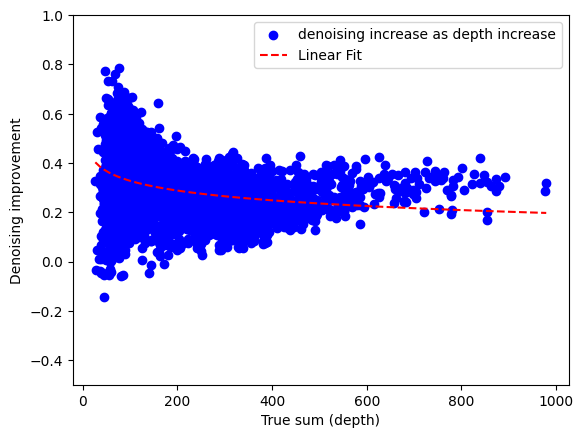

{'reco2noisy': 0.4339508736284179, 'reco2full': 0.6554685812467553, 'noisy2full': 0.3755414703949726}


(5000, 2029)


Calculating MAGIC...


  Running MAGIC on 5000 cells and 2029 genes.


  Calculating graph and diffusion operator...


    Calculating PCA...


    Calculated PCA in 10.09 seconds.


    Calculating KNN search...


    Calculated KNN search in 1.15 seconds.


    Calculating affinities...


    Calculated affinities in 2.57 seconds.


  Calculated graph and diffusion operator in 13.82 seconds.


  Calculating imputation...


  Calculated imputation in 0.02 seconds.


Calculated MAGIC in 13.92 seconds.


corr with zeros: 
{'reco2full': 0.42569998890153415, 'noisy2full': 0.6988666652610273}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.38673033120236566, 'cell_wise_to_noisy': 0.3374748544242122}
depth-wise plot


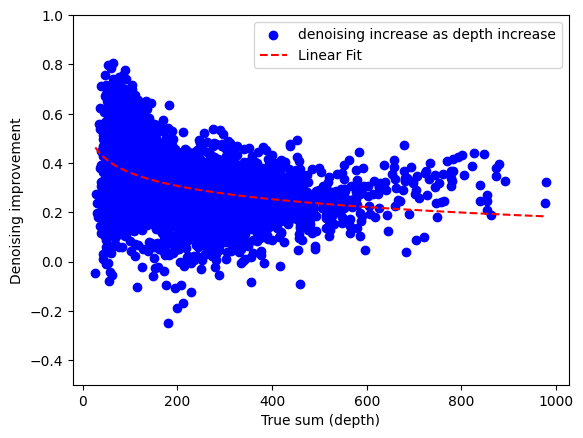

{'reco2noisy': 0.284991261274778, 'reco2full': 0.6611559332833505, 'noisy2full': 0.3751215394403108}
--------------------------------

doing  kidney


1888.9308


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 39176 renamining


filtered out 0 cells, 39176 renamining


Removed 0 genes not known to the ontology


Removed 0 duplicate genes
Added 33718 genes in the ontology but not present in the dataset


starting QC


Seeing 3467 outliers (8.85% of total dataset):


done
AnnData object with n_obs × n_vars = 39176 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl', 'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_c

working on 2132 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<03:14,  1.28it/s]

  1%|          | 3/250 [00:00<01:00,  4.08it/s]

  2%|▏         | 5/250 [00:01<00:38,  6.44it/s]

  3%|▎         | 7/250 [00:01<00:29,  8.35it/s]

  4%|▎         | 9/250 [00:01<00:24,  9.87it/s]

  4%|▍         | 11/250 [00:01<00:21, 11.01it/s]

  5%|▌         | 13/250 [00:01<00:19, 11.87it/s]

  6%|▌         | 15/250 [00:01<00:18, 12.41it/s]

  7%|▋         | 17/250 [00:01<00:18, 12.86it/s]

  8%|▊         | 19/250 [00:02<00:17, 13.19it/s]

  8%|▊         | 21/250 [00:02<00:16, 13.49it/s]

  9%|▉         | 23/250 [00:02<00:16, 13.67it/s]

 10%|█         | 25/250 [00:02<00:16, 13.84it/s]

 11%|█         | 27/250 [00:02<00:15, 13.97it/s]

 12%|█▏        | 29/250 [00:02<00:15, 14.05it/s]

 12%|█▏        | 31/250 [00:02<00:15, 14.09it/s]

 13%|█▎        | 33/250 [00:03<00:15, 14.13it/s]

 14%|█▍        | 35/250 [00:03<00:15, 14.17it/s]

 15%|█▍        | 37/250 [00:03<00:15, 14.19it/s]

 16%|█▌        | 39/250 [00:03<00:14, 14.19it/s]

 16%|█▋        | 41/250 [00:03<00:14, 14.19it/s]

 17%|█▋        | 43/250 [00:03<00:14, 14.13it/s]

 18%|█▊        | 45/250 [00:03<00:14, 14.06it/s]

 19%|█▉        | 47/250 [00:04<00:14, 14.05it/s]

 20%|█▉        | 49/250 [00:04<00:14, 14.10it/s]

 20%|██        | 51/250 [00:04<00:14, 14.09it/s]

 21%|██        | 53/250 [00:04<00:14, 14.06it/s]

 22%|██▏       | 55/250 [00:04<00:13, 14.07it/s]

 23%|██▎       | 57/250 [00:04<00:13, 14.04it/s]

 24%|██▎       | 59/250 [00:04<00:13, 14.01it/s]

 24%|██▍       | 61/250 [00:05<00:13, 14.05it/s]

 25%|██▌       | 63/250 [00:05<00:13, 14.02it/s]

 26%|██▌       | 65/250 [00:05<00:13, 14.00it/s]

 27%|██▋       | 67/250 [00:05<00:13, 14.04it/s]

 28%|██▊       | 69/250 [00:05<00:12, 14.02it/s]

 28%|██▊       | 71/250 [00:05<00:12, 13.97it/s]

 29%|██▉       | 73/250 [00:05<00:12, 13.98it/s]

 30%|███       | 75/250 [00:06<00:12, 13.94it/s]

 31%|███       | 77/250 [00:06<00:12, 13.96it/s]

 32%|███▏      | 79/250 [00:06<00:12, 14.02it/s]

 32%|███▏      | 81/250 [00:06<00:12, 14.00it/s]

 33%|███▎      | 83/250 [00:06<00:11, 13.97it/s]

 34%|███▍      | 85/250 [00:06<00:11, 14.01it/s]

 35%|███▍      | 87/250 [00:06<00:11, 13.99it/s]

 36%|███▌      | 89/250 [00:07<00:11, 13.97it/s]

 36%|███▋      | 91/250 [00:07<00:11, 14.01it/s]

 37%|███▋      | 93/250 [00:07<00:11, 13.98it/s]

 38%|███▊      | 95/250 [00:07<00:11, 13.99it/s]

 39%|███▉      | 97/250 [00:07<00:10, 14.02it/s]

 40%|███▉      | 99/250 [00:07<00:10, 13.96it/s]

 40%|████      | 101/250 [00:07<00:10, 13.96it/s]

 41%|████      | 103/250 [00:08<00:10, 13.99it/s]

 42%|████▏     | 105/250 [00:08<00:10, 13.98it/s]

 43%|████▎     | 107/250 [00:08<00:10, 13.96it/s]

 44%|████▎     | 109/250 [00:08<00:10, 13.99it/s]

 44%|████▍     | 111/250 [00:08<00:09, 13.97it/s]

 45%|████▌     | 113/250 [00:08<00:09, 13.93it/s]

 46%|████▌     | 115/250 [00:08<00:09, 13.95it/s]

 47%|████▋     | 117/250 [00:09<00:09, 13.92it/s]

 48%|████▊     | 119/250 [00:09<00:09, 13.91it/s]

 48%|████▊     | 121/250 [00:09<00:09, 13.94it/s]

 49%|████▉     | 123/250 [00:09<00:09, 13.91it/s]

 50%|█████     | 125/250 [00:09<00:09, 13.87it/s]

 51%|█████     | 127/250 [00:09<00:08, 13.89it/s]

 52%|█████▏    | 129/250 [00:09<00:08, 13.87it/s]

 52%|█████▏    | 131/250 [00:10<00:08, 13.84it/s]

 53%|█████▎    | 133/250 [00:10<00:08, 13.87it/s]

 54%|█████▍    | 135/250 [00:10<00:08, 13.85it/s]

 55%|█████▍    | 137/250 [00:10<00:08, 13.81it/s]

 56%|█████▌    | 139/250 [00:10<00:08, 13.86it/s]

 56%|█████▋    | 141/250 [00:10<00:07, 13.83it/s]

 57%|█████▋    | 143/250 [00:10<00:07, 13.82it/s]

 58%|█████▊    | 145/250 [00:11<00:07, 13.85it/s]

 59%|█████▉    | 147/250 [00:11<00:07, 13.82it/s]

 60%|█████▉    | 149/250 [00:11<00:07, 13.79it/s]

 60%|██████    | 151/250 [00:11<00:07, 13.83it/s]

 61%|██████    | 153/250 [00:11<00:07, 13.80it/s]

 62%|██████▏   | 155/250 [00:11<00:06, 13.78it/s]

 63%|██████▎   | 157/250 [00:11<00:06, 13.82it/s]

 64%|██████▎   | 159/250 [00:12<00:06, 13.79it/s]

 64%|██████▍   | 161/250 [00:12<00:06, 13.77it/s]

 65%|██████▌   | 163/250 [00:12<00:06, 13.80it/s]

 66%|██████▌   | 165/250 [00:12<00:06, 13.77it/s]

 67%|██████▋   | 167/250 [00:12<00:06, 13.75it/s]

 68%|██████▊   | 169/250 [00:12<00:05, 13.78it/s]

 68%|██████▊   | 171/250 [00:12<00:05, 13.75it/s]

 69%|██████▉   | 173/250 [00:13<00:05, 13.73it/s]

 70%|███████   | 175/250 [00:13<00:05, 13.77it/s]

 71%|███████   | 177/250 [00:13<00:05, 13.74it/s]

 72%|███████▏  | 179/250 [00:13<00:05, 13.72it/s]

 72%|███████▏  | 181/250 [00:13<00:05, 13.75it/s]

 73%|███████▎  | 183/250 [00:13<00:04, 13.73it/s]

 74%|███████▍  | 185/250 [00:13<00:04, 13.71it/s]

 75%|███████▍  | 187/250 [00:14<00:04, 13.73it/s]

 76%|███████▌  | 189/250 [00:14<00:04, 13.70it/s]

 76%|███████▋  | 191/250 [00:14<00:04, 13.69it/s]

 77%|███████▋  | 193/250 [00:14<00:04, 13.72it/s]

 78%|███████▊  | 195/250 [00:14<00:04, 13.70it/s]

 79%|███████▉  | 197/250 [00:14<00:04, 12.23it/s]

 80%|███████▉  | 199/250 [00:15<00:04, 12.42it/s]

 80%|████████  | 201/250 [00:15<00:03, 12.54it/s]

 81%|████████  | 203/250 [00:15<00:03, 12.60it/s]

 82%|████████▏ | 205/250 [00:15<00:03, 12.66it/s]

 83%|████████▎ | 207/250 [00:15<00:03, 12.67it/s]

 84%|████████▎ | 209/250 [00:15<00:03, 12.64it/s]

 84%|████████▍ | 211/250 [00:15<00:03, 12.74it/s]

 85%|████████▌ | 213/250 [00:16<00:02, 12.75it/s]

 86%|████████▌ | 215/250 [00:16<00:02, 12.75it/s]

 87%|████████▋ | 217/250 [00:16<00:02, 12.75it/s]

 88%|████████▊ | 219/250 [00:16<00:02, 12.71it/s]

 88%|████████▊ | 221/250 [00:16<00:02, 12.66it/s]

 89%|████████▉ | 223/250 [00:16<00:02, 12.73it/s]

 90%|█████████ | 225/250 [00:17<00:01, 12.73it/s]

 91%|█████████ | 227/250 [00:17<00:01, 12.71it/s]

 92%|█████████▏| 229/250 [00:17<00:01, 12.70it/s]

 92%|█████████▏| 231/250 [00:17<00:01, 12.68it/s]

 93%|█████████▎| 233/250 [00:17<00:01, 12.63it/s]

 94%|█████████▍| 235/250 [00:17<00:01, 12.62it/s]

 95%|█████████▍| 237/250 [00:18<00:01, 12.64it/s]

 96%|█████████▌| 239/250 [00:18<00:00, 12.65it/s]

 96%|█████████▋| 241/250 [00:18<00:00, 12.55it/s]

 97%|█████████▋| 243/250 [00:18<00:00, 12.55it/s]

 98%|█████████▊| 245/250 [00:18<00:00, 12.53it/s]

 99%|█████████▉| 247/250 [00:18<00:00, 12.53it/s]

100%|█████████▉| 249/250 [00:18<00:00, 12.56it/s]

100%|██████████| 250/250 [00:19<00:00, 13.00it/s]

logging the anndata


AnnData object with n_obs × n_vars = 5000 × 2132
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


corr with zeros: 
{'reco2full': 0.40332410190832463, 'noisy2full': 0.685950771159043}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.39655675691292375, 'cell_wise_to_noisy': 0.20981360396265655}
depth-wise plot


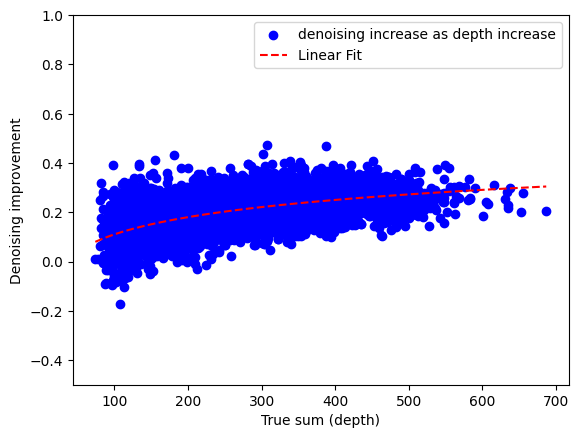

{'reco2noisy': 0.46437429301213295, 'reco2full': 0.621302499066574, 'noisy2full': 0.3632188462198001}


(5000, 2132)


Calculating MAGIC...


  Running MAGIC on 5000 cells and 2132 genes.


  Calculating graph and diffusion operator...


    Calculating PCA...


    Calculated PCA in 7.02 seconds.


    Calculating KNN search...


    Calculated KNN search in 0.98 seconds.


    Calculating affinities...


    Calculated affinities in 0.07 seconds.


  Calculated graph and diffusion operator in 8.08 seconds.


  Calculating imputation...


  Calculated imputation in 0.02 seconds.


Calculated MAGIC in 8.18 seconds.


corr with zeros: 
{'reco2full': 0.499290972818801, 'noisy2full': 0.6855160420036743}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.4846918359695166, 'cell_wise_to_noisy': 0.23613068840004595}
depth-wise plot


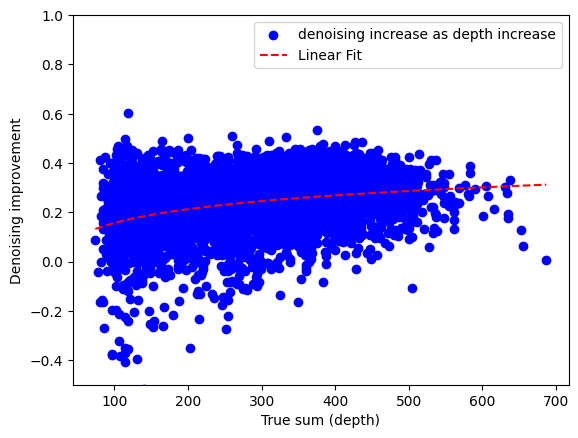

{'reco2noisy': 0.2508119427518947, 'reco2full': 0.6157721783035492, 'noisy2full': 0.36220016465141475}
--------------------------------

doing  glio_smart_highdepth



390864.47
Dropping layers:  KeysView(LayersView with keys: )
checking raw counts


removed 0 non primary cells, 3566 renamining
filtered out 12 cells, 3554 renamining


Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47967 genes in the ontology but not present in the dataset


starting QC
Seeing 71 outliers (2.00% of total dataset):


done
AnnData object with n_obs × n_vars = 3554 × 70116
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_gen

working on 4636 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/178 [00:00<?, ?it/s]

  1%|          | 1/178 [00:00<02:39,  1.11it/s]

  1%|          | 2/178 [00:01<01:25,  2.06it/s]

  2%|▏         | 3/178 [00:01<01:02,  2.81it/s]

  2%|▏         | 4/178 [00:01<00:51,  3.40it/s]

  3%|▎         | 5/178 [00:01<00:45,  3.84it/s]

  3%|▎         | 6/178 [00:01<00:41,  4.17it/s]

  4%|▍         | 7/178 [00:02<00:38,  4.43it/s]

  4%|▍         | 8/178 [00:02<00:36,  4.61it/s]

  5%|▌         | 9/178 [00:02<00:35,  4.74it/s]

  6%|▌         | 10/178 [00:02<00:34,  4.84it/s]

  6%|▌         | 11/178 [00:02<00:34,  4.87it/s]

  7%|▋         | 12/178 [00:03<00:33,  4.93it/s]

  7%|▋         | 13/178 [00:03<00:33,  4.97it/s]

  8%|▊         | 14/178 [00:03<00:33,  4.95it/s]

  8%|▊         | 15/178 [00:03<00:32,  4.99it/s]

  9%|▉         | 16/178 [00:03<00:32,  5.00it/s]

 10%|▉         | 17/178 [00:04<00:32,  5.02it/s]

 10%|█         | 18/178 [00:04<00:31,  5.03it/s]

 11%|█         | 19/178 [00:04<00:31,  4.97it/s]

 11%|█         | 20/178 [00:04<00:31,  4.94it/s]

 12%|█▏        | 21/178 [00:04<00:31,  4.97it/s]

 12%|█▏        | 22/178 [00:05<00:31,  4.98it/s]

 13%|█▎        | 23/178 [00:05<00:31,  4.93it/s]

 13%|█▎        | 24/178 [00:05<00:30,  4.97it/s]

 14%|█▍        | 25/178 [00:05<00:30,  4.99it/s]

 15%|█▍        | 26/178 [00:05<00:30,  5.01it/s]

 15%|█▌        | 27/178 [00:06<00:30,  5.01it/s]

 16%|█▌        | 28/178 [00:06<00:29,  5.03it/s]

 16%|█▋        | 29/178 [00:06<00:29,  5.02it/s]

 17%|█▋        | 30/178 [00:06<00:29,  5.04it/s]

 17%|█▋        | 31/178 [00:06<00:29,  5.03it/s]

 18%|█▊        | 32/178 [00:07<00:29,  5.03it/s]

 19%|█▊        | 33/178 [00:07<00:29,  4.92it/s]

 19%|█▉        | 34/178 [00:07<00:28,  5.03it/s]

 20%|█▉        | 35/178 [00:07<00:28,  5.03it/s]

 20%|██        | 36/178 [00:07<00:28,  5.03it/s]

 21%|██        | 37/178 [00:08<00:28,  5.03it/s]

 21%|██▏       | 38/178 [00:08<00:27,  5.04it/s]

 22%|██▏       | 39/178 [00:08<00:27,  5.04it/s]

 22%|██▏       | 40/178 [00:08<00:28,  4.90it/s]

 23%|██▎       | 41/178 [00:08<00:28,  4.81it/s]

 24%|██▎       | 42/178 [00:09<00:27,  4.88it/s]

 24%|██▍       | 43/178 [00:09<00:27,  4.93it/s]

 25%|██▍       | 44/178 [00:09<00:27,  4.93it/s]

 25%|██▌       | 45/178 [00:09<00:26,  4.96it/s]

 26%|██▌       | 46/178 [00:09<00:26,  4.98it/s]

 26%|██▋       | 47/178 [00:10<00:26,  4.97it/s]

 27%|██▋       | 48/178 [00:10<00:26,  4.99it/s]

 28%|██▊       | 49/178 [00:10<00:25,  5.01it/s]

 28%|██▊       | 50/178 [00:10<00:25,  4.99it/s]

 29%|██▊       | 51/178 [00:10<00:25,  5.00it/s]

 29%|██▉       | 52/178 [00:11<00:25,  5.01it/s]

 30%|██▉       | 53/178 [00:11<00:25,  4.99it/s]

 30%|███       | 54/178 [00:11<00:24,  5.00it/s]

 31%|███       | 55/178 [00:11<00:24,  5.01it/s]

 31%|███▏      | 56/178 [00:11<00:24,  4.98it/s]

 32%|███▏      | 57/178 [00:12<00:24,  5.00it/s]

 33%|███▎      | 58/178 [00:12<00:24,  5.00it/s]

 33%|███▎      | 59/178 [00:12<00:23,  4.98it/s]

 34%|███▎      | 60/178 [00:12<00:23,  5.00it/s]

 34%|███▍      | 61/178 [00:12<00:23,  5.00it/s]

 35%|███▍      | 62/178 [00:13<00:23,  4.99it/s]

 35%|███▌      | 63/178 [00:13<00:23,  5.00it/s]

 36%|███▌      | 64/178 [00:13<00:22,  5.01it/s]

 37%|███▋      | 65/178 [00:13<00:22,  4.99it/s]

 37%|███▋      | 66/178 [00:13<00:22,  5.00it/s]

 38%|███▊      | 67/178 [00:14<00:22,  5.00it/s]

 38%|███▊      | 68/178 [00:14<00:21,  5.00it/s]

 39%|███▉      | 69/178 [00:14<00:21,  5.01it/s]

 39%|███▉      | 70/178 [00:14<00:21,  5.01it/s]

 40%|███▉      | 71/178 [00:14<00:21,  4.99it/s]

 40%|████      | 72/178 [00:15<00:21,  5.00it/s]

 41%|████      | 73/178 [00:15<00:20,  5.00it/s]

 42%|████▏     | 74/178 [00:15<00:20,  5.00it/s]

 42%|████▏     | 75/178 [00:15<00:20,  5.00it/s]

 43%|████▎     | 76/178 [00:15<00:20,  5.01it/s]

 43%|████▎     | 77/178 [00:16<00:20,  5.00it/s]

 44%|████▍     | 78/178 [00:16<00:19,  5.01it/s]

 44%|████▍     | 79/178 [00:16<00:19,  5.01it/s]

 45%|████▍     | 80/178 [00:16<00:19,  5.00it/s]

 46%|████▌     | 81/178 [00:16<00:19,  4.99it/s]

 46%|████▌     | 82/178 [00:17<00:19,  5.00it/s]

 47%|████▋     | 83/178 [00:17<00:19,  4.98it/s]

 47%|████▋     | 84/178 [00:17<00:18,  4.99it/s]

 48%|████▊     | 85/178 [00:17<00:18,  5.00it/s]

 48%|████▊     | 86/178 [00:17<00:18,  4.97it/s]

 49%|████▉     | 87/178 [00:18<00:18,  4.98it/s]

 49%|████▉     | 88/178 [00:18<00:18,  4.99it/s]

 50%|█████     | 89/178 [00:18<00:17,  4.98it/s]

 51%|█████     | 90/178 [00:18<00:17,  4.99it/s]

 51%|█████     | 91/178 [00:18<00:17,  4.99it/s]

 52%|█████▏    | 92/178 [00:19<00:18,  4.58it/s]

 52%|█████▏    | 93/178 [00:19<00:18,  4.66it/s]

 53%|█████▎    | 94/178 [00:19<00:17,  4.72it/s]

 53%|█████▎    | 95/178 [00:19<00:17,  4.76it/s]

 54%|█████▍    | 96/178 [00:19<00:17,  4.78it/s]

 54%|█████▍    | 97/178 [00:20<00:16,  4.80it/s]

 55%|█████▌    | 98/178 [00:20<00:16,  4.82it/s]

 56%|█████▌    | 99/178 [00:20<00:16,  4.83it/s]

 56%|█████▌    | 100/178 [00:20<00:16,  4.83it/s]

 57%|█████▋    | 101/178 [00:21<00:15,  4.83it/s]

 57%|█████▋    | 102/178 [00:21<00:15,  4.82it/s]

 58%|█████▊    | 103/178 [00:21<00:15,  4.82it/s]

 58%|█████▊    | 104/178 [00:21<00:15,  4.84it/s]

 59%|█████▉    | 105/178 [00:21<00:15,  4.84it/s]

 60%|█████▉    | 106/178 [00:22<00:14,  4.83it/s]

 60%|██████    | 107/178 [00:22<00:14,  4.83it/s]

 61%|██████    | 108/178 [00:22<00:14,  4.82it/s]

 61%|██████    | 109/178 [00:22<00:14,  4.82it/s]

 62%|██████▏   | 110/178 [00:22<00:14,  4.83it/s]

 62%|██████▏   | 111/178 [00:23<00:13,  4.83it/s]

 63%|██████▎   | 112/178 [00:23<00:13,  4.82it/s]

 63%|██████▎   | 113/178 [00:23<00:13,  4.81it/s]

 64%|██████▍   | 114/178 [00:23<00:13,  4.81it/s]

 65%|██████▍   | 115/178 [00:23<00:13,  4.82it/s]

 65%|██████▌   | 116/178 [00:24<00:12,  4.82it/s]

 66%|██████▌   | 117/178 [00:24<00:12,  4.82it/s]

 66%|██████▋   | 118/178 [00:24<00:12,  4.82it/s]

 67%|██████▋   | 119/178 [00:24<00:12,  4.82it/s]

 67%|██████▋   | 120/178 [00:24<00:12,  4.83it/s]

 68%|██████▊   | 121/178 [00:25<00:11,  4.83it/s]

 69%|██████▊   | 122/178 [00:25<00:11,  4.83it/s]

 69%|██████▉   | 123/178 [00:25<00:11,  4.82it/s]

 70%|██████▉   | 124/178 [00:25<00:11,  4.80it/s]

 70%|███████   | 125/178 [00:26<00:11,  4.80it/s]

 71%|███████   | 126/178 [00:26<00:10,  4.82it/s]

 71%|███████▏  | 127/178 [00:26<00:10,  4.81it/s]

 72%|███████▏  | 128/178 [00:26<00:10,  4.81it/s]

 72%|███████▏  | 129/178 [00:26<00:10,  4.80it/s]

 73%|███████▎  | 130/178 [00:27<00:10,  4.80it/s]

 74%|███████▎  | 131/178 [00:27<00:09,  4.80it/s]

 74%|███████▍  | 132/178 [00:27<00:09,  4.81it/s]

 75%|███████▍  | 133/178 [00:27<00:09,  4.81it/s]

 75%|███████▌  | 134/178 [00:27<00:09,  4.80it/s]

 76%|███████▌  | 135/178 [00:28<00:08,  4.78it/s]

 76%|███████▋  | 136/178 [00:28<00:08,  4.78it/s]

 77%|███████▋  | 137/178 [00:28<00:08,  4.78it/s]

 78%|███████▊  | 138/178 [00:28<00:08,  4.79it/s]

 78%|███████▊  | 139/178 [00:28<00:08,  4.78it/s]

 79%|███████▊  | 140/178 [00:29<00:07,  4.78it/s]

 79%|███████▉  | 141/178 [00:29<00:07,  4.77it/s]

 80%|███████▉  | 142/178 [00:29<00:07,  4.76it/s]

 80%|████████  | 143/178 [00:29<00:07,  4.77it/s]

 81%|████████  | 144/178 [00:29<00:07,  4.77it/s]

 81%|████████▏ | 145/178 [00:30<00:06,  4.78it/s]

 82%|████████▏ | 146/178 [00:30<00:06,  4.77it/s]

 83%|████████▎ | 147/178 [00:30<00:06,  4.76it/s]

 83%|████████▎ | 148/178 [00:30<00:06,  4.77it/s]

 84%|████████▎ | 149/178 [00:31<00:06,  4.77it/s]

 84%|████████▍ | 150/178 [00:31<00:05,  4.77it/s]

 85%|████████▍ | 151/178 [00:31<00:05,  4.77it/s]

 85%|████████▌ | 152/178 [00:31<00:05,  4.76it/s]

 86%|████████▌ | 153/178 [00:31<00:05,  4.77it/s]

 87%|████████▋ | 154/178 [00:32<00:05,  4.77it/s]

 87%|████████▋ | 155/178 [00:32<00:04,  4.78it/s]

 88%|████████▊ | 156/178 [00:32<00:04,  4.77it/s]

 88%|████████▊ | 157/178 [00:32<00:04,  4.77it/s]

 89%|████████▉ | 158/178 [00:32<00:04,  4.76it/s]

 89%|████████▉ | 159/178 [00:33<00:03,  4.75it/s]

 90%|████████▉ | 160/178 [00:33<00:03,  4.76it/s]

 90%|█████████ | 161/178 [00:33<00:03,  4.77it/s]

 91%|█████████ | 162/178 [00:33<00:03,  4.76it/s]

 92%|█████████▏| 163/178 [00:33<00:03,  4.75it/s]

 92%|█████████▏| 164/178 [00:34<00:02,  4.74it/s]

 93%|█████████▎| 165/178 [00:34<00:02,  4.74it/s]

 93%|█████████▎| 166/178 [00:34<00:02,  4.73it/s]

 94%|█████████▍| 167/178 [00:34<00:02,  4.73it/s]

 94%|█████████▍| 168/178 [00:35<00:02,  4.71it/s]

 95%|█████████▍| 169/178 [00:35<00:01,  4.71it/s]

 96%|█████████▌| 170/178 [00:35<00:01,  4.70it/s]

 96%|█████████▌| 171/178 [00:35<00:01,  4.72it/s]

 97%|█████████▋| 172/178 [00:35<00:01,  4.71it/s]

 97%|█████████▋| 173/178 [00:36<00:01,  4.71it/s]

 98%|█████████▊| 174/178 [00:36<00:00,  4.70it/s]

 98%|█████████▊| 175/178 [00:36<00:00,  4.69it/s]

 99%|█████████▉| 176/178 [00:36<00:00,  4.69it/s]

 99%|█████████▉| 177/178 [00:36<00:00,  4.70it/s]

100%|██████████| 178/178 [00:37<00:00,  4.38it/s]

100%|██████████| 178/178 [00:37<00:00,  4.76it/s]

logging the anndata


AnnData object with n_obs × n_vars = 3554 × 4636
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


corr with zeros: 
{'reco2full': 0.31810335200175194, 'noisy2full': 0.7566499808271685}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.31828223543829465, 'cell_wise_to_noisy': 0.26485020905582646}
depth-wise plot


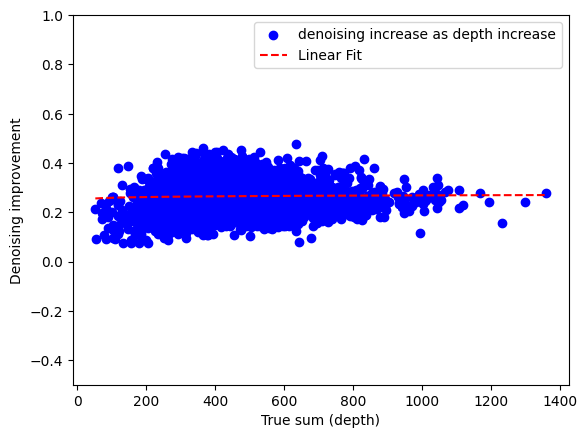

{'reco2noisy': 0.7202098910523466, 'reco2full': 0.6920554752157152, 'noisy2full': 0.41126740467999334}


(3554, 4636)


Calculating MAGIC...


  Running MAGIC on 3554 cells and 4636 genes.


  Calculating graph and diffusion operator...


    Calculating PCA...


    Calculated PCA in 14.90 seconds.


    Calculating KNN search...


    Calculated KNN search in 0.64 seconds.


    Calculating affinities...


    Calculated affinities in 0.15 seconds.


  Calculated graph and diffusion operator in 15.70 seconds.


  Calculating imputation...


  Calculated imputation in 0.01 seconds.


Calculated MAGIC in 15.80 seconds.


corr with zeros: 
{'reco2full': 0.416790317158972, 'noisy2full': 0.7565747519332386}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.41025628166737255, 'cell_wise_to_noisy': 0.0983275325764776}
depth-wise plot


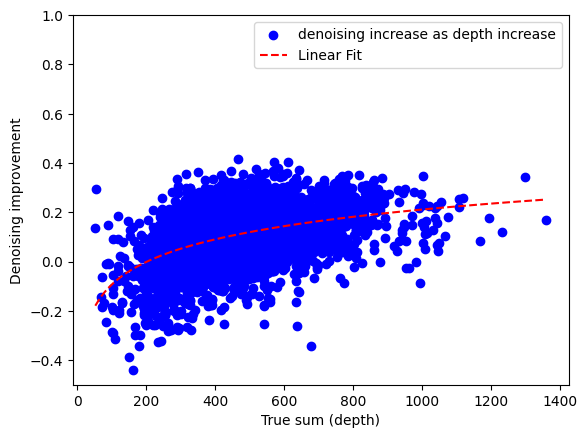

{'reco2noisy': 0.23322329815345733, 'reco2full': 0.5350945676814473, 'noisy2full': 0.4103917032140123}
--------------------------------

doing  lung_smart



10360.862


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 9409 renamining


filtered out 0 cells, 9409 renamining


Removed 0 genes not known to the ontology


Removed 0 duplicate genes
Added 15701 genes in the ontology but not present in the dataset


starting QC


Seeing 5471 outliers (58.14% of total dataset):


done
AnnData object with n_obs × n_vars = 9409 × 70116
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'lo

working on 2916 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<03:46,  1.10it/s]

  1%|          | 3/250 [00:01<01:17,  3.20it/s]

  2%|▏         | 4/250 [00:01<00:59,  4.11it/s]

  2%|▏         | 5/250 [00:01<00:48,  5.06it/s]

  2%|▏         | 6/250 [00:01<00:40,  5.96it/s]

  3%|▎         | 7/250 [00:01<00:35,  6.75it/s]

  3%|▎         | 8/250 [00:01<00:32,  7.42it/s]

  4%|▎         | 9/250 [00:01<00:30,  7.93it/s]

  4%|▍         | 10/250 [00:01<00:28,  8.40it/s]

  4%|▍         | 11/250 [00:01<00:27,  8.71it/s]

  5%|▍         | 12/250 [00:02<00:26,  8.90it/s]

  5%|▌         | 13/250 [00:02<00:26,  9.09it/s]

  6%|▌         | 14/250 [00:02<00:25,  9.26it/s]

  6%|▌         | 15/250 [00:02<00:25,  9.27it/s]

  6%|▋         | 16/250 [00:02<00:24,  9.37it/s]

  7%|▋         | 17/250 [00:02<00:24,  9.41it/s]

  7%|▋         | 18/250 [00:02<00:24,  9.48it/s]

  8%|▊         | 19/250 [00:02<00:24,  9.48it/s]

  8%|▊         | 20/250 [00:02<00:24,  9.51it/s]

  8%|▊         | 21/250 [00:03<00:24,  9.53it/s]

  9%|▉         | 22/250 [00:03<00:23,  9.55it/s]

  9%|▉         | 23/250 [00:03<00:23,  9.54it/s]

 10%|▉         | 24/250 [00:03<00:23,  9.56it/s]

 10%|█         | 25/250 [00:03<00:23,  9.54it/s]

 10%|█         | 26/250 [00:03<00:23,  9.56it/s]

 11%|█         | 27/250 [00:03<00:23,  9.54it/s]

 11%|█         | 28/250 [00:03<00:23,  9.38it/s]

 12%|█▏        | 29/250 [00:03<00:23,  9.25it/s]

 12%|█▏        | 30/250 [00:03<00:23,  9.34it/s]

 12%|█▏        | 31/250 [00:04<00:23,  9.40it/s]

 13%|█▎        | 32/250 [00:04<00:23,  9.44it/s]

 13%|█▎        | 33/250 [00:04<00:22,  9.46it/s]

 14%|█▎        | 34/250 [00:04<00:22,  9.49it/s]

 14%|█▍        | 35/250 [00:04<00:22,  9.50it/s]

 14%|█▍        | 36/250 [00:04<00:22,  9.50it/s]

 15%|█▍        | 37/250 [00:04<00:22,  9.52it/s]

 15%|█▌        | 38/250 [00:04<00:22,  9.51it/s]

 16%|█▌        | 39/250 [00:04<00:22,  9.52it/s]

 16%|█▌        | 40/250 [00:05<00:22,  9.23it/s]

 16%|█▋        | 41/250 [00:05<00:23,  9.06it/s]

 17%|█▋        | 42/250 [00:05<00:22,  9.21it/s]

 17%|█▋        | 43/250 [00:05<00:22,  9.30it/s]

 18%|█▊        | 44/250 [00:05<00:21,  9.37it/s]

 18%|█▊        | 45/250 [00:05<00:21,  9.41it/s]

 18%|█▊        | 46/250 [00:05<00:21,  9.45it/s]

 19%|█▉        | 47/250 [00:05<00:21,  9.47it/s]

 19%|█▉        | 48/250 [00:05<00:21,  9.48it/s]

 20%|█▉        | 49/250 [00:05<00:21,  9.49it/s]

 20%|██        | 50/250 [00:06<00:21,  9.50it/s]

 20%|██        | 51/250 [00:06<00:20,  9.50it/s]

 21%|██        | 52/250 [00:06<00:20,  9.49it/s]

 21%|██        | 53/250 [00:06<00:20,  9.50it/s]

 22%|██▏       | 54/250 [00:06<00:20,  9.51it/s]

 22%|██▏       | 55/250 [00:06<00:20,  9.44it/s]

 22%|██▏       | 56/250 [00:06<00:20,  9.55it/s]

 23%|██▎       | 57/250 [00:06<00:20,  9.56it/s]

 23%|██▎       | 58/250 [00:06<00:20,  9.56it/s]

 24%|██▎       | 59/250 [00:07<00:20,  9.54it/s]

 24%|██▍       | 60/250 [00:07<00:19,  9.55it/s]

 24%|██▍       | 61/250 [00:07<00:19,  9.53it/s]

 25%|██▍       | 62/250 [00:07<00:19,  9.53it/s]

 25%|██▌       | 63/250 [00:07<00:19,  9.53it/s]

 26%|██▌       | 64/250 [00:07<00:19,  9.53it/s]

 26%|██▌       | 65/250 [00:07<00:19,  9.52it/s]

 26%|██▋       | 66/250 [00:07<00:19,  9.52it/s]

 27%|██▋       | 67/250 [00:07<00:19,  9.51it/s]

 27%|██▋       | 68/250 [00:07<00:19,  9.52it/s]

 28%|██▊       | 69/250 [00:08<00:19,  9.52it/s]

 28%|██▊       | 70/250 [00:08<00:18,  9.52it/s]

 28%|██▊       | 71/250 [00:08<00:18,  9.50it/s]

 29%|██▉       | 72/250 [00:08<00:18,  9.52it/s]

 29%|██▉       | 73/250 [00:08<00:18,  9.50it/s]

 30%|██▉       | 74/250 [00:08<00:18,  9.48it/s]

 30%|███       | 75/250 [00:08<00:18,  9.50it/s]

 30%|███       | 76/250 [00:08<00:18,  9.50it/s]

 31%|███       | 77/250 [00:08<00:18,  9.49it/s]

 31%|███       | 78/250 [00:09<00:18,  9.51it/s]

 32%|███▏      | 79/250 [00:09<00:17,  9.50it/s]

 32%|███▏      | 80/250 [00:09<00:19,  8.94it/s]

 32%|███▏      | 81/250 [00:09<00:19,  8.58it/s]

 33%|███▎      | 82/250 [00:09<00:18,  8.85it/s]

 33%|███▎      | 83/250 [00:09<00:18,  9.04it/s]

 34%|███▎      | 84/250 [00:09<00:18,  9.12it/s]

 34%|███▍      | 85/250 [00:09<00:17,  9.24it/s]

 34%|███▍      | 86/250 [00:09<00:17,  9.33it/s]

 35%|███▍      | 87/250 [00:10<00:17,  9.30it/s]

 35%|███▌      | 88/250 [00:10<00:17,  9.37it/s]

 36%|███▌      | 89/250 [00:10<00:17,  9.40it/s]

 36%|███▌      | 90/250 [00:10<00:17,  9.38it/s]

 36%|███▋      | 91/250 [00:10<00:16,  9.39it/s]

 37%|███▋      | 92/250 [00:10<00:16,  9.44it/s]

 37%|███▋      | 93/250 [00:10<00:16,  9.39it/s]

 38%|███▊      | 94/250 [00:10<00:16,  9.42it/s]

 38%|███▊      | 95/250 [00:10<00:16,  9.44it/s]

 38%|███▊      | 96/250 [00:10<00:16,  9.39it/s]

 39%|███▉      | 97/250 [00:11<00:16,  9.42it/s]

 39%|███▉      | 98/250 [00:11<00:16,  9.43it/s]

 40%|███▉      | 99/250 [00:11<00:16,  9.39it/s]

 40%|████      | 100/250 [00:11<00:15,  9.42it/s]

 40%|████      | 101/250 [00:11<00:15,  9.43it/s]

 41%|████      | 102/250 [00:11<00:15,  9.39it/s]

 41%|████      | 103/250 [00:11<00:15,  9.42it/s]

 42%|████▏     | 104/250 [00:11<00:15,  9.42it/s]

 42%|████▏     | 105/250 [00:11<00:15,  9.39it/s]

 42%|████▏     | 106/250 [00:12<00:15,  9.40it/s]

 43%|████▎     | 107/250 [00:12<00:15,  9.43it/s]

 43%|████▎     | 108/250 [00:12<00:15,  9.35it/s]

 44%|████▎     | 109/250 [00:12<00:14,  9.41it/s]

 44%|████▍     | 110/250 [00:12<00:14,  9.41it/s]

 44%|████▍     | 111/250 [00:12<00:14,  9.37it/s]

 45%|████▍     | 112/250 [00:12<00:14,  9.39it/s]

 45%|████▌     | 113/250 [00:12<00:14,  9.42it/s]

 46%|████▌     | 114/250 [00:12<00:14,  9.36it/s]

 46%|████▌     | 115/250 [00:13<00:14,  9.38it/s]

 46%|████▋     | 116/250 [00:13<00:14,  9.40it/s]

 47%|████▋     | 117/250 [00:13<00:14,  9.37it/s]

 47%|████▋     | 118/250 [00:13<00:14,  9.38it/s]

 48%|████▊     | 119/250 [00:13<00:13,  9.40it/s]

 48%|████▊     | 120/250 [00:13<00:13,  9.34it/s]

 48%|████▊     | 121/250 [00:13<00:13,  9.38it/s]

 49%|████▉     | 122/250 [00:13<00:13,  9.38it/s]

 49%|████▉     | 123/250 [00:13<00:13,  9.34it/s]

 50%|████▉     | 124/250 [00:13<00:13,  9.36it/s]

 50%|█████     | 125/250 [00:14<00:13,  9.39it/s]

 50%|█████     | 126/250 [00:14<00:13,  9.28it/s]

 51%|█████     | 127/250 [00:14<00:13,  9.35it/s]

 51%|█████     | 128/250 [00:14<00:13,  9.38it/s]

 52%|█████▏    | 129/250 [00:14<00:12,  9.32it/s]

 52%|█████▏    | 130/250 [00:14<00:12,  9.35it/s]

 52%|█████▏    | 131/250 [00:14<00:12,  9.37it/s]

 53%|█████▎    | 132/250 [00:14<00:12,  9.31it/s]

 53%|█████▎    | 133/250 [00:14<00:12,  9.34it/s]

 54%|█████▎    | 134/250 [00:15<00:12,  9.36it/s]

 54%|█████▍    | 135/250 [00:15<00:12,  9.31it/s]

 54%|█████▍    | 136/250 [00:15<00:12,  9.35it/s]

 55%|█████▍    | 137/250 [00:15<00:12,  9.35it/s]

 55%|█████▌    | 138/250 [00:15<00:12,  9.31it/s]

 56%|█████▌    | 139/250 [00:15<00:11,  9.33it/s]

 56%|█████▌    | 140/250 [00:15<00:11,  9.34it/s]

 56%|█████▋    | 141/250 [00:15<00:11,  9.31it/s]

 57%|█████▋    | 142/250 [00:15<00:11,  9.33it/s]

 57%|█████▋    | 143/250 [00:15<00:11,  9.34it/s]

 58%|█████▊    | 144/250 [00:16<00:13,  7.90it/s]

 58%|█████▊    | 145/250 [00:16<00:12,  8.14it/s]

 58%|█████▊    | 146/250 [00:16<00:12,  8.34it/s]

 59%|█████▉    | 147/250 [00:16<00:12,  8.50it/s]

 59%|█████▉    | 148/250 [00:16<00:11,  8.60it/s]

 60%|█████▉    | 149/250 [00:16<00:11,  8.65it/s]

 60%|██████    | 150/250 [00:16<00:11,  8.72it/s]

 60%|██████    | 151/250 [00:16<00:11,  8.72it/s]

 61%|██████    | 152/250 [00:17<00:11,  8.77it/s]

 61%|██████    | 153/250 [00:17<00:11,  8.78it/s]

 62%|██████▏   | 154/250 [00:17<00:10,  8.78it/s]

 62%|██████▏   | 155/250 [00:17<00:10,  8.81it/s]

 62%|██████▏   | 156/250 [00:17<00:10,  8.82it/s]

 63%|██████▎   | 157/250 [00:17<00:10,  8.82it/s]

 63%|██████▎   | 158/250 [00:17<00:10,  8.81it/s]

 64%|██████▎   | 159/250 [00:17<00:10,  8.77it/s]

 64%|██████▍   | 160/250 [00:17<00:10,  8.78it/s]

 64%|██████▍   | 161/250 [00:18<00:10,  8.77it/s]

 65%|██████▍   | 162/250 [00:18<00:10,  8.77it/s]

 65%|██████▌   | 163/250 [00:18<00:09,  8.76it/s]

 66%|██████▌   | 164/250 [00:18<00:09,  8.74it/s]

 66%|██████▌   | 165/250 [00:18<00:09,  8.78it/s]

 66%|██████▋   | 166/250 [00:18<00:09,  8.77it/s]

 67%|██████▋   | 167/250 [00:18<00:09,  8.78it/s]

 67%|██████▋   | 168/250 [00:18<00:09,  8.76it/s]

 68%|██████▊   | 169/250 [00:19<00:09,  8.75it/s]

 68%|██████▊   | 170/250 [00:19<00:09,  8.76it/s]

 68%|██████▊   | 171/250 [00:19<00:09,  8.77it/s]

 69%|██████▉   | 172/250 [00:19<00:08,  8.76it/s]

 69%|██████▉   | 173/250 [00:19<00:08,  8.80it/s]

 70%|██████▉   | 174/250 [00:19<00:08,  8.78it/s]

 70%|███████   | 175/250 [00:19<00:08,  8.78it/s]

 70%|███████   | 176/250 [00:19<00:08,  8.77it/s]

 71%|███████   | 177/250 [00:19<00:08,  8.77it/s]

 71%|███████   | 178/250 [00:20<00:08,  8.73it/s]

 72%|███████▏  | 179/250 [00:20<00:08,  8.72it/s]

 72%|███████▏  | 180/250 [00:20<00:08,  8.72it/s]

 72%|███████▏  | 181/250 [00:20<00:07,  8.73it/s]

 73%|███████▎  | 182/250 [00:20<00:07,  8.71it/s]

 73%|███████▎  | 183/250 [00:20<00:07,  8.74it/s]

 74%|███████▎  | 184/250 [00:20<00:07,  8.73it/s]

 74%|███████▍  | 185/250 [00:20<00:07,  8.74it/s]

 74%|███████▍  | 186/250 [00:20<00:07,  8.71it/s]

 75%|███████▍  | 187/250 [00:21<00:07,  8.71it/s]

 75%|███████▌  | 188/250 [00:21<00:07,  8.71it/s]

 76%|███████▌  | 189/250 [00:21<00:07,  8.71it/s]

 76%|███████▌  | 190/250 [00:21<00:06,  8.69it/s]

 76%|███████▋  | 191/250 [00:21<00:06,  8.72it/s]

 77%|███████▋  | 192/250 [00:21<00:06,  8.72it/s]

 77%|███████▋  | 193/250 [00:21<00:06,  8.72it/s]

 78%|███████▊  | 194/250 [00:21<00:06,  8.69it/s]

 78%|███████▊  | 195/250 [00:21<00:06,  8.70it/s]

 78%|███████▊  | 196/250 [00:22<00:06,  8.66it/s]

 79%|███████▉  | 197/250 [00:22<00:06,  8.65it/s]

 79%|███████▉  | 198/250 [00:22<00:06,  8.66it/s]

 80%|███████▉  | 199/250 [00:22<00:05,  8.66it/s]

 80%|████████  | 200/250 [00:22<00:05,  8.65it/s]

 80%|████████  | 201/250 [00:22<00:05,  8.67it/s]

 81%|████████  | 202/250 [00:22<00:05,  8.66it/s]

 81%|████████  | 203/250 [00:22<00:05,  8.67it/s]

 82%|████████▏ | 204/250 [00:23<00:05,  8.65it/s]

 82%|████████▏ | 205/250 [00:23<00:05,  8.65it/s]

 82%|████████▏ | 206/250 [00:23<00:05,  8.66it/s]

 83%|████████▎ | 207/250 [00:23<00:04,  8.66it/s]

 83%|████████▎ | 208/250 [00:23<00:04,  8.64it/s]

 84%|████████▎ | 209/250 [00:23<00:04,  8.67it/s]

 84%|████████▍ | 210/250 [00:23<00:04,  8.67it/s]

 84%|████████▍ | 211/250 [00:23<00:04,  8.67it/s]

 85%|████████▍ | 212/250 [00:23<00:04,  8.65it/s]

 85%|████████▌ | 213/250 [00:24<00:04,  8.64it/s]

 86%|████████▌ | 214/250 [00:24<00:04,  8.60it/s]

 86%|████████▌ | 215/250 [00:24<00:04,  8.58it/s]

 86%|████████▋ | 216/250 [00:24<00:03,  8.58it/s]

 87%|████████▋ | 217/250 [00:24<00:03,  8.59it/s]

 87%|████████▋ | 218/250 [00:24<00:03,  8.57it/s]

 88%|████████▊ | 219/250 [00:24<00:03,  8.61it/s]

 88%|████████▊ | 220/250 [00:24<00:03,  8.61it/s]

 88%|████████▊ | 221/250 [00:25<00:03,  8.60it/s]

 89%|████████▉ | 222/250 [00:25<00:03,  8.59it/s]

 89%|████████▉ | 223/250 [00:25<00:03,  7.32it/s]

 90%|████████▉ | 224/250 [00:25<00:03,  7.68it/s]

 90%|█████████ | 225/250 [00:25<00:03,  7.90it/s]

 90%|█████████ | 226/250 [00:25<00:02,  8.09it/s]

 91%|█████████ | 227/250 [00:25<00:02,  8.25it/s]

 91%|█████████ | 228/250 [00:25<00:02,  8.35it/s]

 92%|█████████▏| 229/250 [00:26<00:02,  8.42it/s]

 92%|█████████▏| 230/250 [00:26<00:02,  8.47it/s]

 92%|█████████▏| 231/250 [00:26<00:02,  8.50it/s]

 93%|█████████▎| 232/250 [00:26<00:02,  8.49it/s]

 93%|█████████▎| 233/250 [00:26<00:02,  8.48it/s]

 94%|█████████▎| 234/250 [00:26<00:01,  8.50it/s]

 94%|█████████▍| 235/250 [00:26<00:01,  8.50it/s]

 94%|█████████▍| 236/250 [00:26<00:01,  8.51it/s]

 95%|█████████▍| 237/250 [00:26<00:01,  8.53it/s]

 95%|█████████▌| 238/250 [00:27<00:01,  8.54it/s]

 96%|█████████▌| 239/250 [00:27<00:01,  8.54it/s]

 96%|█████████▌| 240/250 [00:27<00:01,  8.52it/s]

 96%|█████████▋| 241/250 [00:27<00:01,  8.45it/s]

 97%|█████████▋| 242/250 [00:27<00:00,  8.47it/s]

 97%|█████████▋| 243/250 [00:27<00:00,  8.46it/s]

 98%|█████████▊| 244/250 [00:27<00:00,  8.48it/s]

 98%|█████████▊| 245/250 [00:27<00:00,  8.52it/s]

 98%|█████████▊| 246/250 [00:28<00:00,  8.53it/s]

 99%|█████████▉| 247/250 [00:28<00:00,  8.51it/s]

 99%|█████████▉| 248/250 [00:28<00:00,  8.52it/s]

100%|█████████▉| 249/250 [00:28<00:00,  8.50it/s]

100%|██████████| 250/250 [00:28<00:00,  8.48it/s]

100%|██████████| 250/250 [00:28<00:00,  8.71it/s]

logging the anndata


AnnData object with n_obs × n_vars = 5000 × 2916
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


corr with zeros: 
{'reco2full': 0.3207772922607459, 'noisy2full': 0.7622628772484655}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.32585125049084757, 'cell_wise_to_noisy': 0.2580715769661035}
depth-wise plot


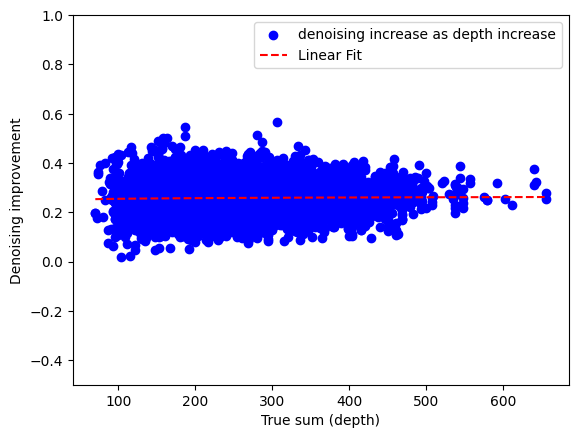

{'reco2noisy': 0.7554086707520378, 'reco2full': 0.6794432516025636, 'noisy2full': 0.40479499114037265}


(5000, 2916)


Calculating MAGIC...


  Running MAGIC on 5000 cells and 2916 genes.


  Calculating graph and diffusion operator...


    Calculating PCA...


    Calculated PCA in 7.38 seconds.


    Calculating KNN search...


    Calculated KNN search in 0.32 seconds.


    Calculating affinities...


    Calculated affinities in 0.07 seconds.


  Calculated graph and diffusion operator in 7.79 seconds.


  Calculating imputation...


  Calculated imputation in 0.02 seconds.


Calculated MAGIC in 7.90 seconds.


corr with zeros: 
{'reco2full': 0.4014855850746693, 'noisy2full': 0.762097508588617}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.39794480484601463, 'cell_wise_to_noisy': 0.2138217010999776}
depth-wise plot


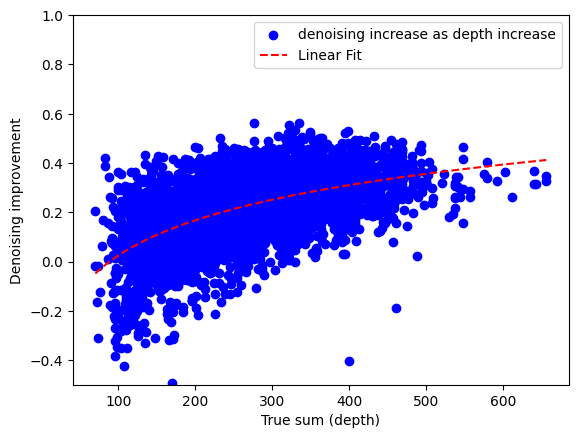

{'reco2noisy': 0.2778288004244021, 'reco2full': 0.6567158864438954, 'noisy2full': 0.4033502098693669}
--------------------------------

doing  SRX24486462



43356.863
Dropping layers:  KeysView(LayersView with keys: ambiguous, norm, spliced, unspliced)


checking raw counts


removed 0 non primary cells, 5201 renamining


filtered out 0 cells, 5201 renamining


Removed 0 genes not known to the ontology


Removed 0 duplicate genes
Added 0 genes in the ontology but not present in the dataset


starting QC


Seeing 5091 outliers (97.87% of total dataset):


done
AnnData object with n_obs × n_vars = 5201 × 70116
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'sex', 'sex_ontology_term_id', 'age', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'ethnicity', 'is_primary_data', 'cell_culture', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'batches', 'leiden_2', 'leiden_1', 'leiden_0.5', 'clust_cell_type', 'simplified_dev_stage', 'age_group'
    var: 'feature_types', 'ensembl_ontology_term_id', 'uid_x', 'symbol_x', 'biotype_x', 'organism_id_x', 'mt_x', 'ribo_

working on 3991 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 1/250 [00:00<03:34,  1.16it/s]

  1%|          | 2/250 [00:01<01:51,  2.23it/s]

  1%|          | 3/250 [00:01<01:18,  3.15it/s]

  2%|▏         | 4/250 [00:01<01:02,  3.91it/s]

  2%|▏         | 5/250 [00:01<00:54,  4.50it/s]

  2%|▏         | 6/250 [00:01<00:48,  4.98it/s]

  3%|▎         | 7/250 [00:01<00:45,  5.32it/s]

  3%|▎         | 8/250 [00:01<00:43,  5.55it/s]

  4%|▎         | 9/250 [00:02<00:42,  5.71it/s]

  4%|▍         | 10/250 [00:02<00:41,  5.82it/s]

  4%|▍         | 11/250 [00:02<00:40,  5.89it/s]

  5%|▍         | 12/250 [00:02<00:39,  5.95it/s]

  5%|▌         | 13/250 [00:02<00:39,  6.05it/s]

  6%|▌         | 14/250 [00:02<00:38,  6.09it/s]

  6%|▌         | 15/250 [00:03<00:38,  6.14it/s]

  6%|▋         | 16/250 [00:03<00:38,  6.14it/s]

  7%|▋         | 17/250 [00:03<00:37,  6.17it/s]

  7%|▋         | 18/250 [00:03<00:37,  6.11it/s]

  8%|▊         | 19/250 [00:03<00:37,  6.14it/s]

  8%|▊         | 20/250 [00:03<00:37,  6.14it/s]

  8%|▊         | 21/250 [00:04<00:37,  6.16it/s]

  9%|▉         | 22/250 [00:04<00:37,  6.16it/s]

  9%|▉         | 23/250 [00:04<00:37,  6.06it/s]

 10%|▉         | 24/250 [00:04<00:37,  6.09it/s]

 10%|█         | 25/250 [00:04<00:36,  6.11it/s]

 10%|█         | 26/250 [00:04<00:36,  6.12it/s]

 11%|█         | 27/250 [00:05<00:36,  6.14it/s]

 11%|█         | 28/250 [00:05<00:36,  6.14it/s]

 12%|█▏        | 29/250 [00:05<00:35,  6.15it/s]

 12%|█▏        | 30/250 [00:05<00:35,  6.14it/s]

 12%|█▏        | 31/250 [00:05<00:35,  6.15it/s]

 13%|█▎        | 32/250 [00:05<00:35,  6.15it/s]

 13%|█▎        | 33/250 [00:06<00:35,  6.14it/s]

 14%|█▎        | 34/250 [00:06<00:35,  6.11it/s]

 14%|█▍        | 35/250 [00:06<00:35,  6.14it/s]

 14%|█▍        | 36/250 [00:06<00:34,  6.15it/s]

 15%|█▍        | 37/250 [00:06<00:34,  6.15it/s]

 15%|█▌        | 38/250 [00:06<00:34,  6.15it/s]

 16%|█▌        | 39/250 [00:07<00:34,  6.15it/s]

 16%|█▌        | 40/250 [00:07<00:34,  6.14it/s]

 16%|█▋        | 41/250 [00:07<00:33,  6.16it/s]

 17%|█▋        | 42/250 [00:07<00:33,  6.17it/s]

 17%|█▋        | 43/250 [00:07<00:33,  6.16it/s]

 18%|█▊        | 44/250 [00:07<00:33,  6.15it/s]

 18%|█▊        | 45/250 [00:08<00:33,  6.17it/s]

 18%|█▊        | 46/250 [00:08<00:33,  6.14it/s]

 19%|█▉        | 47/250 [00:08<00:32,  6.15it/s]

 19%|█▉        | 48/250 [00:08<00:32,  6.16it/s]

 20%|█▉        | 49/250 [00:08<00:32,  6.14it/s]

 20%|██        | 50/250 [00:08<00:32,  6.15it/s]

 20%|██        | 51/250 [00:08<00:32,  6.16it/s]

 21%|██        | 52/250 [00:09<00:32,  6.15it/s]

 21%|██        | 53/250 [00:09<00:31,  6.16it/s]

 22%|██▏       | 54/250 [00:09<00:31,  6.16it/s]

 22%|██▏       | 55/250 [00:09<00:31,  6.13it/s]

 22%|██▏       | 56/250 [00:09<00:31,  6.14it/s]

 23%|██▎       | 57/250 [00:09<00:31,  6.15it/s]

 23%|██▎       | 58/250 [00:10<00:31,  6.12it/s]

 24%|██▎       | 59/250 [00:10<00:31,  6.13it/s]

 24%|██▍       | 60/250 [00:10<00:30,  6.14it/s]

 24%|██▍       | 61/250 [00:10<00:30,  6.14it/s]

 25%|██▍       | 62/250 [00:10<00:30,  6.15it/s]

 25%|██▌       | 63/250 [00:10<00:30,  6.15it/s]

 26%|██▌       | 64/250 [00:11<00:30,  6.12it/s]

 26%|██▌       | 65/250 [00:11<00:30,  6.13it/s]

 26%|██▋       | 66/250 [00:11<00:29,  6.14it/s]

 27%|██▋       | 67/250 [00:11<00:29,  6.13it/s]

 27%|██▋       | 68/250 [00:11<00:29,  6.14it/s]

 28%|██▊       | 69/250 [00:11<00:29,  6.14it/s]

 28%|██▊       | 70/250 [00:12<00:29,  6.14it/s]

 28%|██▊       | 71/250 [00:12<00:29,  6.14it/s]

 29%|██▉       | 72/250 [00:12<00:28,  6.15it/s]

 29%|██▉       | 73/250 [00:12<00:28,  6.11it/s]

 30%|██▉       | 74/250 [00:12<00:28,  6.13it/s]

 30%|███       | 75/250 [00:12<00:28,  6.13it/s]

 30%|███       | 76/250 [00:13<00:28,  6.13it/s]

 31%|███       | 77/250 [00:13<00:28,  6.13it/s]

 31%|███       | 78/250 [00:13<00:28,  6.14it/s]

 32%|███▏      | 79/250 [00:13<00:28,  6.10it/s]

 32%|███▏      | 80/250 [00:13<00:27,  6.12it/s]

 32%|███▏      | 81/250 [00:13<00:27,  6.12it/s]

 33%|███▎      | 82/250 [00:14<00:27,  6.10it/s]

 33%|███▎      | 83/250 [00:14<00:27,  6.10it/s]

 34%|███▎      | 84/250 [00:14<00:27,  6.11it/s]

 34%|███▍      | 85/250 [00:14<00:27,  6.10it/s]

 34%|███▍      | 86/250 [00:14<00:26,  6.12it/s]

 35%|███▍      | 87/250 [00:14<00:26,  6.12it/s]

 35%|███▌      | 88/250 [00:15<00:26,  6.09it/s]

 36%|███▌      | 89/250 [00:15<00:26,  6.10it/s]

 36%|███▌      | 90/250 [00:15<00:26,  6.12it/s]

 36%|███▋      | 91/250 [00:15<00:26,  6.08it/s]

 37%|███▋      | 92/250 [00:15<00:25,  6.10it/s]

 37%|███▋      | 93/250 [00:15<00:25,  6.05it/s]

 38%|███▊      | 94/250 [00:16<00:25,  6.02it/s]

 38%|███▊      | 95/250 [00:16<00:25,  6.05it/s]

 38%|███▊      | 96/250 [00:16<00:25,  6.06it/s]

 39%|███▉      | 97/250 [00:16<00:25,  6.05it/s]

 39%|███▉      | 98/250 [00:16<00:25,  6.07it/s]

 40%|███▉      | 99/250 [00:16<00:24,  6.09it/s]

 40%|████      | 100/250 [00:17<00:24,  6.09it/s]

 40%|████      | 101/250 [00:17<00:24,  6.10it/s]

 41%|████      | 102/250 [00:17<00:24,  6.11it/s]

 41%|████      | 103/250 [00:17<00:24,  6.08it/s]

 42%|████▏     | 104/250 [00:17<00:23,  6.09it/s]

 42%|████▏     | 105/250 [00:17<00:23,  6.10it/s]

 42%|████▏     | 106/250 [00:18<00:25,  5.70it/s]

 43%|████▎     | 107/250 [00:18<00:24,  5.75it/s]

 43%|████▎     | 108/250 [00:18<00:24,  5.79it/s]

 44%|████▎     | 109/250 [00:18<00:24,  5.81it/s]

 44%|████▍     | 110/250 [00:18<00:24,  5.82it/s]

 44%|████▍     | 111/250 [00:18<00:23,  5.84it/s]

 45%|████▍     | 112/250 [00:19<00:23,  5.84it/s]

 45%|████▌     | 113/250 [00:19<00:23,  5.85it/s]

 46%|████▌     | 114/250 [00:19<00:23,  5.84it/s]

 46%|████▌     | 115/250 [00:19<00:23,  5.82it/s]

 46%|████▋     | 116/250 [00:19<00:22,  5.83it/s]

 47%|████▋     | 117/250 [00:19<00:22,  5.83it/s]

 47%|████▋     | 118/250 [00:20<00:22,  5.82it/s]

 48%|████▊     | 119/250 [00:20<00:22,  5.83it/s]

 48%|████▊     | 120/250 [00:20<00:22,  5.83it/s]

 48%|████▊     | 121/250 [00:20<00:22,  5.82it/s]

 49%|████▉     | 122/250 [00:20<00:22,  5.81it/s]

 49%|████▉     | 123/250 [00:20<00:21,  5.81it/s]

 50%|████▉     | 124/250 [00:21<00:21,  5.81it/s]

 50%|█████     | 125/250 [00:21<00:21,  5.81it/s]

 50%|█████     | 126/250 [00:21<00:21,  5.81it/s]

 51%|█████     | 127/250 [00:21<00:21,  5.81it/s]

 51%|█████     | 128/250 [00:21<00:20,  5.82it/s]

 52%|█████▏    | 129/250 [00:21<00:20,  5.81it/s]

 52%|█████▏    | 130/250 [00:22<00:20,  5.81it/s]

 52%|█████▏    | 131/250 [00:22<00:20,  5.80it/s]

 53%|█████▎    | 132/250 [00:22<00:20,  5.81it/s]

 53%|█████▎    | 133/250 [00:22<00:21,  5.57it/s]

 54%|█████▎    | 134/250 [00:22<00:20,  5.66it/s]

 54%|█████▍    | 135/250 [00:23<00:20,  5.69it/s]

 54%|█████▍    | 136/250 [00:23<00:19,  5.72it/s]

 55%|█████▍    | 137/250 [00:23<00:19,  5.75it/s]

 55%|█████▌    | 138/250 [00:23<00:19,  5.77it/s]

 56%|█████▌    | 139/250 [00:23<00:19,  5.77it/s]

 56%|█████▌    | 140/250 [00:23<00:19,  5.77it/s]

 56%|█████▋    | 141/250 [00:24<00:18,  5.76it/s]

 57%|█████▋    | 142/250 [00:24<00:18,  5.77it/s]

 57%|█████▋    | 143/250 [00:24<00:18,  5.76it/s]

 58%|█████▊    | 144/250 [00:24<00:18,  5.76it/s]

 58%|█████▊    | 145/250 [00:24<00:18,  5.76it/s]

 58%|█████▊    | 146/250 [00:24<00:17,  5.79it/s]

 59%|█████▉    | 147/250 [00:25<00:17,  5.78it/s]

 59%|█████▉    | 148/250 [00:25<00:17,  5.79it/s]

 60%|█████▉    | 149/250 [00:25<00:17,  5.78it/s]

 60%|██████    | 150/250 [00:25<00:17,  5.77it/s]

 60%|██████    | 151/250 [00:25<00:17,  5.78it/s]

 61%|██████    | 152/250 [00:25<00:16,  5.77it/s]

 61%|██████    | 153/250 [00:26<00:16,  5.76it/s]

 62%|██████▏   | 154/250 [00:26<00:16,  5.77it/s]

 62%|██████▏   | 155/250 [00:26<00:16,  5.76it/s]

 62%|██████▏   | 156/250 [00:26<00:16,  5.76it/s]

 63%|██████▎   | 157/250 [00:26<00:16,  5.76it/s]

 63%|██████▎   | 158/250 [00:27<00:15,  5.76it/s]

 64%|██████▎   | 159/250 [00:27<00:15,  5.74it/s]

 64%|██████▍   | 160/250 [00:27<00:15,  5.76it/s]

 64%|██████▍   | 161/250 [00:27<00:15,  5.75it/s]

 65%|██████▍   | 162/250 [00:27<00:15,  5.75it/s]

 65%|██████▌   | 163/250 [00:27<00:15,  5.74it/s]

 66%|██████▌   | 164/250 [00:28<00:15,  5.73it/s]

 66%|██████▌   | 165/250 [00:28<00:14,  5.73it/s]

 66%|██████▋   | 166/250 [00:28<00:14,  5.74it/s]

 67%|██████▋   | 167/250 [00:28<00:14,  5.74it/s]

 67%|██████▋   | 168/250 [00:28<00:14,  5.74it/s]

 68%|██████▊   | 169/250 [00:28<00:14,  5.74it/s]

 68%|██████▊   | 170/250 [00:29<00:13,  5.73it/s]

 68%|██████▊   | 171/250 [00:29<00:13,  5.73it/s]

 69%|██████▉   | 172/250 [00:29<00:13,  5.74it/s]

 69%|██████▉   | 173/250 [00:29<00:13,  5.74it/s]

 70%|██████▉   | 174/250 [00:29<00:13,  5.74it/s]

 70%|███████   | 175/250 [00:29<00:13,  5.74it/s]

 70%|███████   | 176/250 [00:30<00:12,  5.72it/s]

 71%|███████   | 177/250 [00:30<00:12,  5.72it/s]

 71%|███████   | 178/250 [00:30<00:12,  5.71it/s]

 72%|███████▏  | 179/250 [00:30<00:12,  5.71it/s]

 72%|███████▏  | 180/250 [00:30<00:12,  5.72it/s]

 72%|███████▏  | 181/250 [00:31<00:12,  5.72it/s]

 73%|███████▎  | 182/250 [00:31<00:11,  5.71it/s]

 73%|███████▎  | 183/250 [00:31<00:11,  5.72it/s]

 74%|███████▎  | 184/250 [00:31<00:11,  5.71it/s]

 74%|███████▍  | 185/250 [00:31<00:11,  5.71it/s]

 74%|███████▍  | 186/250 [00:31<00:11,  5.72it/s]

 75%|███████▍  | 187/250 [00:32<00:11,  5.70it/s]

 75%|███████▌  | 188/250 [00:32<00:10,  5.69it/s]

 76%|███████▌  | 189/250 [00:32<00:10,  5.69it/s]

 76%|███████▌  | 190/250 [00:32<00:10,  5.68it/s]

 76%|███████▋  | 191/250 [00:32<00:10,  5.68it/s]

 77%|███████▋  | 192/250 [00:32<00:10,  5.71it/s]

 77%|███████▋  | 193/250 [00:33<00:09,  5.70it/s]

 78%|███████▊  | 194/250 [00:33<00:09,  5.70it/s]

 78%|███████▊  | 195/250 [00:33<00:09,  5.69it/s]

 78%|███████▊  | 196/250 [00:33<00:09,  5.68it/s]

 79%|███████▉  | 197/250 [00:33<00:09,  5.69it/s]

 79%|███████▉  | 198/250 [00:34<00:09,  5.68it/s]

 80%|███████▉  | 199/250 [00:34<00:08,  5.67it/s]

 80%|████████  | 200/250 [00:34<00:08,  5.68it/s]

 80%|████████  | 201/250 [00:34<00:08,  5.67it/s]

 81%|████████  | 202/250 [00:34<00:08,  5.67it/s]

 81%|████████  | 203/250 [00:34<00:08,  5.67it/s]

 82%|████████▏ | 204/250 [00:35<00:08,  5.66it/s]

 82%|████████▏ | 205/250 [00:35<00:07,  5.65it/s]

 82%|████████▏ | 206/250 [00:35<00:07,  5.66it/s]

 83%|████████▎ | 207/250 [00:35<00:07,  5.66it/s]

 83%|████████▎ | 208/250 [00:35<00:07,  5.66it/s]

 84%|████████▎ | 209/250 [00:35<00:07,  5.65it/s]

 84%|████████▍ | 210/250 [00:36<00:07,  5.64it/s]

 84%|████████▍ | 211/250 [00:36<00:06,  5.64it/s]

 85%|████████▍ | 212/250 [00:36<00:06,  5.65it/s]

 85%|████████▌ | 213/250 [00:36<00:06,  5.65it/s]

 86%|████████▌ | 214/250 [00:36<00:06,  5.65it/s]

 86%|████████▌ | 215/250 [00:37<00:06,  5.64it/s]

 86%|████████▋ | 216/250 [00:37<00:06,  5.63it/s]

 87%|████████▋ | 217/250 [00:37<00:05,  5.63it/s]

 87%|████████▋ | 218/250 [00:37<00:05,  5.63it/s]

 88%|████████▊ | 219/250 [00:37<00:05,  5.62it/s]

 88%|████████▊ | 220/250 [00:37<00:05,  5.62it/s]

 88%|████████▊ | 221/250 [00:38<00:05,  5.62it/s]

 89%|████████▉ | 222/250 [00:38<00:04,  5.61it/s]

 89%|████████▉ | 223/250 [00:38<00:04,  5.62it/s]

 90%|████████▉ | 224/250 [00:38<00:04,  5.62it/s]

 90%|█████████ | 225/250 [00:38<00:04,  5.62it/s]

 90%|█████████ | 226/250 [00:38<00:04,  5.62it/s]

 91%|█████████ | 227/250 [00:39<00:04,  5.62it/s]

 91%|█████████ | 228/250 [00:39<00:03,  5.62it/s]

 92%|█████████▏| 229/250 [00:39<00:03,  5.63it/s]

 92%|█████████▏| 230/250 [00:39<00:03,  5.63it/s]

 92%|█████████▏| 231/250 [00:39<00:03,  5.62it/s]

 93%|█████████▎| 232/250 [00:40<00:03,  5.61it/s]

 93%|█████████▎| 233/250 [00:40<00:03,  5.63it/s]

 94%|█████████▎| 234/250 [00:40<00:02,  5.62it/s]

 94%|█████████▍| 235/250 [00:40<00:02,  5.61it/s]

 94%|█████████▍| 236/250 [00:40<00:02,  5.60it/s]

 95%|█████████▍| 237/250 [00:40<00:02,  5.60it/s]

 95%|█████████▌| 238/250 [00:41<00:02,  5.60it/s]

 96%|█████████▌| 239/250 [00:41<00:01,  5.59it/s]

 96%|█████████▌| 240/250 [00:41<00:01,  5.59it/s]

 96%|█████████▋| 241/250 [00:41<00:01,  5.58it/s]

 97%|█████████▋| 242/250 [00:41<00:01,  5.59it/s]

 97%|█████████▋| 243/250 [00:42<00:01,  5.59it/s]

 98%|█████████▊| 244/250 [00:42<00:01,  5.58it/s]

 98%|█████████▊| 245/250 [00:42<00:00,  5.58it/s]

 98%|█████████▊| 246/250 [00:42<00:00,  5.59it/s]

 99%|█████████▉| 247/250 [00:42<00:00,  5.59it/s]

 99%|█████████▉| 248/250 [00:42<00:00,  5.58it/s]

100%|█████████▉| 249/250 [00:43<00:00,  5.59it/s]

100%|██████████| 250/250 [00:43<00:00,  5.58it/s]

100%|██████████| 250/250 [00:43<00:00,  5.75it/s]

logging the anndata


AnnData object with n_obs × n_vars = 5000 × 3991
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


corr with zeros: 
{'reco2full': 0.6771830703550907, 'noisy2full': 0.6763018547878408}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.6526035723309708, 'cell_wise_to_noisy': 0.3608183408830982}
depth-wise plot


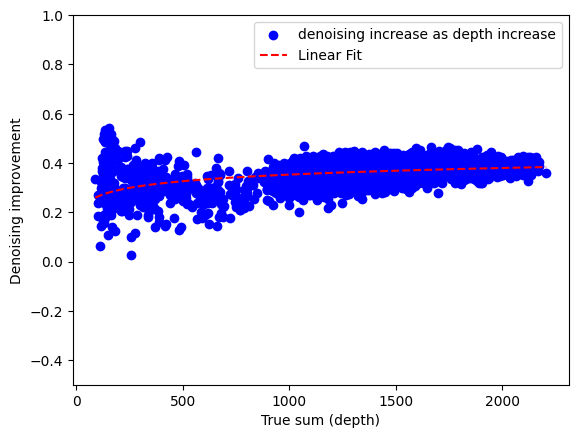

{'reco2noisy': 0.43229902384500046, 'reco2full': 0.7774741140503048, 'noisy2full': 0.4059382688729161}


(5000, 3991)


Calculating MAGIC...


  Running MAGIC on 5000 cells and 3991 genes.


  Calculating graph and diffusion operator...


    Calculating PCA...


    Calculated PCA in 10.95 seconds.


    Calculating KNN search...


    Calculated KNN search in 0.19 seconds.


    Calculating affinities...


    Calculated affinities in 0.08 seconds.


  Calculated graph and diffusion operator in 11.22 seconds.


  Calculating imputation...


  Calculated imputation in 0.02 seconds.


Calculated MAGIC in 11.41 seconds.


corr with zeros: 
{'reco2full': 0.741977458413629, 'noisy2full': 0.6761106948806596}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.7257248401861335, 'cell_wise_to_noisy': 0.3824062408277395}
depth-wise plot


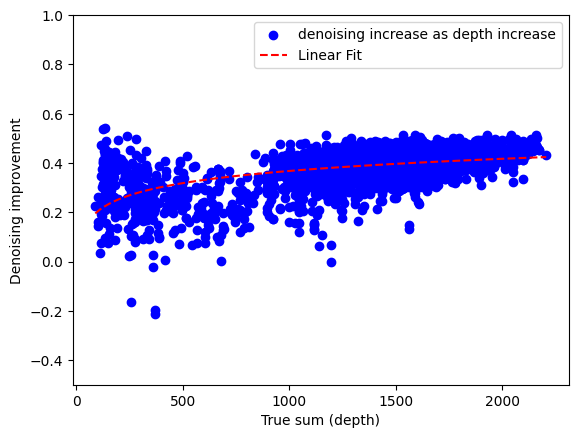

{'reco2noisy': 0.3222249753068737, 'reco2full': 0.7768165992477237, 'noisy2full': 0.40544226090199253}
--------------------------------

doing  SRX22526970



22621.557
Dropping layers:  KeysView(LayersView with keys: ambiguous, norm, spliced, unspliced)


checking raw counts


removed 0 non primary cells, 3110 renamining


filtered out 0 cells, 3110 renamining


Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 0 genes in the ontology but not present in the dataset


starting QC


Seeing 766 outliers (24.62% of total dataset):


done
AnnData object with n_obs × n_vars = 3110 × 70116
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'sex', 'sex_ontology_term_id', 'age', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'ethnicity', 'is_primary_data', 'cell_culture', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'batches', 'leiden_2', 'leiden_1', 'leiden_0.5', 'clust_cell_type', 'simplified_dev_stage', 'age_group'
    var: 'feature_types', 'ensembl_ontology_term_id', 'uid_x', 'symbol_x', 'biotype_x', 'organism_id_x', 'mt_x', 'ribo_

working on 3839 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/156 [00:00<?, ?it/s]

  1%|          | 1/156 [00:00<02:17,  1.13it/s]

  1%|▏         | 2/156 [00:01<01:10,  2.19it/s]

  2%|▏         | 3/156 [00:01<00:49,  3.11it/s]

  3%|▎         | 4/156 [00:01<00:38,  3.93it/s]

  3%|▎         | 5/156 [00:01<00:32,  4.61it/s]

  4%|▍         | 6/156 [00:01<00:29,  5.15it/s]

  4%|▍         | 7/156 [00:01<00:26,  5.57it/s]

  5%|▌         | 8/156 [00:01<00:25,  5.90it/s]

  6%|▌         | 9/156 [00:02<00:24,  6.10it/s]

  6%|▋         | 10/156 [00:02<00:23,  6.24it/s]

  7%|▋         | 11/156 [00:02<00:22,  6.38it/s]

  8%|▊         | 12/156 [00:02<00:22,  6.47it/s]

  8%|▊         | 13/156 [00:02<00:22,  6.48it/s]

  9%|▉         | 14/156 [00:02<00:21,  6.50it/s]

 10%|▉         | 15/156 [00:03<00:21,  6.56it/s]

 10%|█         | 16/156 [00:03<00:21,  6.61it/s]

 11%|█         | 17/156 [00:03<00:20,  6.63it/s]

 12%|█▏        | 18/156 [00:03<00:20,  6.65it/s]

 12%|█▏        | 19/156 [00:03<00:20,  6.59it/s]

 13%|█▎        | 20/156 [00:03<00:20,  6.62it/s]

 13%|█▎        | 21/156 [00:03<00:20,  6.64it/s]

 14%|█▍        | 22/156 [00:04<00:20,  6.57it/s]

 15%|█▍        | 23/156 [00:04<00:20,  6.58it/s]

 15%|█▌        | 24/156 [00:04<00:19,  6.61it/s]

 16%|█▌        | 25/156 [00:04<00:19,  6.63it/s]

 17%|█▋        | 26/156 [00:04<00:19,  6.64it/s]

 17%|█▋        | 27/156 [00:04<00:19,  6.63it/s]

 18%|█▊        | 28/156 [00:04<00:19,  6.65it/s]

 19%|█▊        | 29/156 [00:05<00:19,  6.66it/s]

 19%|█▉        | 30/156 [00:05<00:18,  6.65it/s]

 20%|█▉        | 31/156 [00:05<00:18,  6.66it/s]

 21%|██        | 32/156 [00:05<00:18,  6.67it/s]

 21%|██        | 33/156 [00:05<00:18,  6.68it/s]

 22%|██▏       | 34/156 [00:05<00:18,  6.66it/s]

 22%|██▏       | 35/156 [00:06<00:18,  6.69it/s]

 23%|██▎       | 36/156 [00:06<00:18,  6.66it/s]

 24%|██▎       | 37/156 [00:06<00:17,  6.67it/s]

 24%|██▍       | 38/156 [00:06<00:17,  6.67it/s]

 25%|██▌       | 39/156 [00:06<00:17,  6.65it/s]

 26%|██▌       | 40/156 [00:06<00:17,  6.66it/s]

 26%|██▋       | 41/156 [00:06<00:17,  6.67it/s]

 27%|██▋       | 42/156 [00:07<00:17,  6.66it/s]

 28%|██▊       | 43/156 [00:07<00:16,  6.68it/s]

 28%|██▊       | 44/156 [00:07<00:16,  6.68it/s]

 29%|██▉       | 45/156 [00:07<00:16,  6.65it/s]

 29%|██▉       | 46/156 [00:07<00:16,  6.67it/s]

 30%|███       | 47/156 [00:07<00:16,  6.68it/s]

 31%|███       | 48/156 [00:07<00:16,  6.64it/s]

 31%|███▏      | 49/156 [00:08<00:16,  6.66it/s]

 32%|███▏      | 50/156 [00:08<00:15,  6.67it/s]

 33%|███▎      | 51/156 [00:08<00:15,  6.67it/s]

 33%|███▎      | 52/156 [00:08<00:15,  6.67it/s]

 34%|███▍      | 53/156 [00:08<00:15,  6.68it/s]

 35%|███▍      | 54/156 [00:08<00:15,  6.65it/s]

 35%|███▌      | 55/156 [00:09<00:15,  6.66it/s]

 36%|███▌      | 56/156 [00:09<00:15,  6.67it/s]

 37%|███▋      | 57/156 [00:09<00:14,  6.64it/s]

 37%|███▋      | 58/156 [00:09<00:14,  6.65it/s]

 38%|███▊      | 59/156 [00:09<00:14,  6.67it/s]

 38%|███▊      | 60/156 [00:09<00:14,  6.66it/s]

 39%|███▉      | 61/156 [00:09<00:14,  6.67it/s]

 40%|███▉      | 62/156 [00:10<00:14,  6.66it/s]

 40%|████      | 63/156 [00:10<00:13,  6.66it/s]

 41%|████      | 64/156 [00:10<00:13,  6.67it/s]

 42%|████▏     | 65/156 [00:10<00:13,  6.67it/s]

 42%|████▏     | 66/156 [00:10<00:13,  6.63it/s]

 43%|████▎     | 67/156 [00:10<00:13,  6.64it/s]

 44%|████▎     | 68/156 [00:10<00:13,  6.65it/s]

 44%|████▍     | 69/156 [00:11<00:13,  6.63it/s]

 45%|████▍     | 70/156 [00:11<00:12,  6.64it/s]

 46%|████▌     | 71/156 [00:11<00:12,  6.65it/s]

 46%|████▌     | 72/156 [00:11<00:12,  6.65it/s]

 47%|████▋     | 73/156 [00:11<00:12,  6.66it/s]

 47%|████▋     | 74/156 [00:11<00:12,  6.66it/s]

 48%|████▊     | 75/156 [00:12<00:12,  6.62it/s]

 49%|████▊     | 76/156 [00:12<00:12,  6.62it/s]

 49%|████▉     | 77/156 [00:12<00:11,  6.64it/s]

 50%|█████     | 78/156 [00:12<00:11,  6.60it/s]

 51%|█████     | 79/156 [00:12<00:11,  6.62it/s]

 51%|█████▏    | 80/156 [00:12<00:11,  6.63it/s]

 52%|█████▏    | 81/156 [00:12<00:11,  6.61it/s]

 53%|█████▎    | 82/156 [00:13<00:11,  6.62it/s]

 53%|█████▎    | 83/156 [00:13<00:11,  6.63it/s]

 54%|█████▍    | 84/156 [00:13<00:10,  6.59it/s]

 54%|█████▍    | 85/156 [00:13<00:10,  6.60it/s]

 55%|█████▌    | 86/156 [00:13<00:10,  6.61it/s]

 56%|█████▌    | 87/156 [00:13<00:10,  6.58it/s]

 56%|█████▋    | 88/156 [00:13<00:10,  6.60it/s]

 57%|█████▋    | 89/156 [00:14<00:10,  6.60it/s]

 58%|█████▊    | 90/156 [00:14<00:09,  6.60it/s]

 58%|█████▊    | 91/156 [00:14<00:09,  6.61it/s]

 59%|█████▉    | 92/156 [00:14<00:09,  6.62it/s]

 60%|█████▉    | 93/156 [00:14<00:09,  6.58it/s]

 60%|██████    | 94/156 [00:14<00:09,  6.59it/s]

 61%|██████    | 95/156 [00:15<00:09,  6.61it/s]

 62%|██████▏   | 96/156 [00:15<00:09,  6.57it/s]

 62%|██████▏   | 97/156 [00:15<00:08,  6.58it/s]

 63%|██████▎   | 98/156 [00:15<00:08,  6.60it/s]

 63%|██████▎   | 99/156 [00:15<00:08,  6.59it/s]

 64%|██████▍   | 100/156 [00:15<00:08,  6.61it/s]

 65%|██████▍   | 101/156 [00:15<00:08,  6.61it/s]

 65%|██████▌   | 102/156 [00:16<00:08,  6.57it/s]

 66%|██████▌   | 103/156 [00:16<00:08,  6.58it/s]

 67%|██████▋   | 104/156 [00:16<00:07,  6.60it/s]

 67%|██████▋   | 105/156 [00:16<00:07,  6.57it/s]

 68%|██████▊   | 106/156 [00:16<00:07,  6.58it/s]

 69%|██████▊   | 107/156 [00:16<00:07,  6.59it/s]

 69%|██████▉   | 108/156 [00:17<00:07,  6.59it/s]

 70%|██████▉   | 109/156 [00:17<00:07,  6.60it/s]

 71%|███████   | 110/156 [00:17<00:06,  6.60it/s]

 71%|███████   | 111/156 [00:17<00:07,  6.10it/s]

 72%|███████▏  | 112/156 [00:17<00:07,  6.17it/s]

 72%|███████▏  | 113/156 [00:17<00:06,  6.20it/s]

 73%|███████▎  | 114/156 [00:18<00:06,  6.23it/s]

 74%|███████▎  | 115/156 [00:18<00:06,  6.26it/s]

 74%|███████▍  | 116/156 [00:18<00:06,  6.28it/s]

 75%|███████▌  | 117/156 [00:18<00:06,  6.30it/s]

 76%|███████▌  | 118/156 [00:18<00:06,  6.31it/s]

 76%|███████▋  | 119/156 [00:18<00:05,  6.30it/s]

 77%|███████▋  | 120/156 [00:18<00:05,  6.30it/s]

 78%|███████▊  | 121/156 [00:19<00:05,  6.31it/s]

 78%|███████▊  | 122/156 [00:19<00:05,  6.31it/s]

 79%|███████▉  | 123/156 [00:19<00:05,  6.34it/s]

 79%|███████▉  | 124/156 [00:19<00:05,  6.34it/s]

 80%|████████  | 125/156 [00:19<00:04,  6.31it/s]

 81%|████████  | 126/156 [00:19<00:04,  6.32it/s]

 81%|████████▏ | 127/156 [00:20<00:04,  6.32it/s]

 82%|████████▏ | 128/156 [00:20<00:04,  6.30it/s]

 83%|████████▎ | 129/156 [00:20<00:04,  6.28it/s]

 83%|████████▎ | 130/156 [00:20<00:04,  6.29it/s]

 84%|████████▍ | 131/156 [00:20<00:03,  6.28it/s]

 85%|████████▍ | 132/156 [00:20<00:03,  6.29it/s]

 85%|████████▌ | 133/156 [00:21<00:03,  6.29it/s]

 86%|████████▌ | 134/156 [00:21<00:03,  6.26it/s]

 87%|████████▋ | 135/156 [00:21<00:03,  6.26it/s]

 87%|████████▋ | 136/156 [00:21<00:03,  6.26it/s]

 88%|████████▊ | 137/156 [00:21<00:03,  6.26it/s]

 88%|████████▊ | 138/156 [00:21<00:02,  6.28it/s]

 89%|████████▉ | 139/156 [00:21<00:02,  6.28it/s]

 90%|████████▉ | 140/156 [00:22<00:02,  6.26it/s]

 90%|█████████ | 141/156 [00:22<00:02,  6.26it/s]

 91%|█████████ | 142/156 [00:22<00:02,  6.27it/s]

 92%|█████████▏| 143/156 [00:22<00:02,  6.27it/s]

 92%|█████████▏| 144/156 [00:22<00:01,  6.29it/s]

 93%|█████████▎| 145/156 [00:22<00:01,  6.28it/s]

 94%|█████████▎| 146/156 [00:23<00:01,  6.26it/s]

 94%|█████████▍| 147/156 [00:23<00:01,  6.26it/s]

 95%|█████████▍| 148/156 [00:23<00:01,  6.27it/s]

 96%|█████████▌| 149/156 [00:23<00:01,  6.25it/s]

 96%|█████████▌| 150/156 [00:23<00:00,  6.24it/s]

 97%|█████████▋| 151/156 [00:23<00:00,  6.25it/s]

 97%|█████████▋| 152/156 [00:24<00:00,  6.26it/s]

 98%|█████████▊| 153/156 [00:24<00:00,  6.26it/s]

 99%|█████████▊| 154/156 [00:24<00:00,  6.26it/s]

 99%|█████████▉| 155/156 [00:24<00:00,  6.22it/s]

100%|██████████| 156/156 [00:24<00:00,  6.19it/s]

100%|██████████| 156/156 [00:24<00:00,  6.28it/s]

logging the anndata


AnnData object with n_obs × n_vars = 3110 × 3839
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


corr with zeros: 
{'reco2full': 0.667185106141912, 'noisy2full': 0.702504933843631}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.6494261839217131, 'cell_wise_to_noisy': 0.4606751884833125}
depth-wise plot


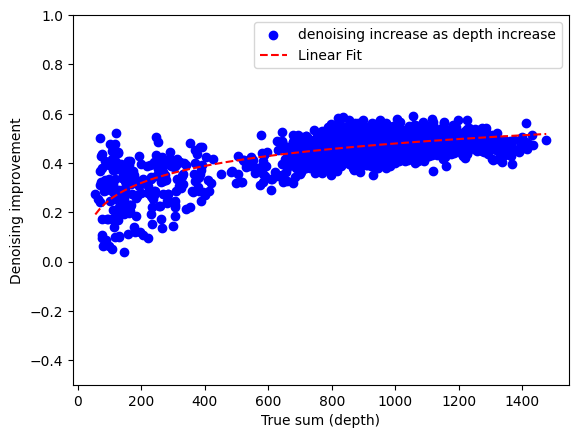

{'reco2noisy': 0.46082154696620553, 'reco2full': 0.89772992592398, 'noisy2full': 0.42016039971248753}


(3110, 3839)


Calculating MAGIC...


  Running MAGIC on 3110 cells and 3839 genes.


  Calculating graph and diffusion operator...


    Calculating PCA...


    Calculated PCA in 6.53 seconds.


    Calculating KNN search...


    Calculated KNN search in 0.54 seconds.


    Calculating affinities...


    Calculated affinities in 0.65 seconds.


  Calculated graph and diffusion operator in 7.73 seconds.


  Calculating imputation...


  Calculated imputation in 0.01 seconds.


Calculated MAGIC in 7.82 seconds.


corr with zeros: 
{'reco2full': 0.6811427648304932, 'noisy2full': 0.702537217686189}


cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': 0.6668502114226633, 'cell_wise_to_noisy': 0.4748585693770238}
depth-wise plot


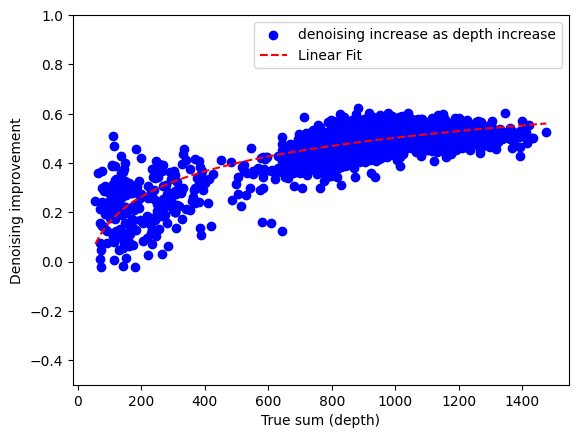

{'reco2noisy': 0.3887641930765449, 'reco2full': 0.9117881478434162, 'noisy2full': 0.4206831279462776}
--------------------------------



In [6]:
res = {}
for name, url in datasets.items():
    print("doing ", name)

    adata = sc.read(LOC + name + ".h5ad", backup_url=url)
    max_len = 3000 if (adata.X > 0).sum(1).mean() < 2_000 else 5000
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        # drop_non_primary=False,
        do_postp=False,
    )
    print("")
    adata = adata[adata.X.sum(1) > 1000]
    print(adata.X.sum(1).mean())
    adata = preprocessor(adata)
    adata.layers["true"] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if (adata.X > 0).sum(1).mean() < 2_000 else 20,
        max_len=max_len,
        max_cells=5_000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=10,
        downsample_expr=0.7,
        additional_info=True,
        apply_zero_pred=True,
    )
    res["scprint_" + name], idx, nadata = denoise(model, adata)
    print(res["scprint_" + name])

    # doing magic
    subadata = (
        adata[idx, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy()
        if idx is not None
        else adata[
            :, adata.var.index.isin(model.genes) & adata.var.highly_variable
        ].copy()
    )
    print(subadata.shape)
    subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
    denoised_adata = sc.external.pp.magic(
        subadata.copy(), copy=True, n_jobs=10, solver="approximate", verbose=True
    )

    reco = denoised_adata.X
    true = subadata.layers["true"].toarray()
    noisy = subadata.X
    corr_coef, p_value = spearmanr(
        np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
    )
    res["magic_" + name] = {
        "reco2noisy": corr_coef[0, 1],
        "reco2full": corr_coef[0, 2],
        "noisy2full": corr_coef[1, 2],
    }
    if reco.shape[0] <= 3000:
        indices = np.random.choice(reco.shape[0], 3000, replace=False)
        reco = reco[indices]
        noisy = noisy[indices]
        true = true[indices]
    corr, p_value = spearmanr(
        np.vstack(
            [
                reco.flatten(),
                noisy.flatten(),
                true.flatten(),
            ]
        ).T
    )
    m = {
        "reco2full": corr[0, 2],
        "noisy2full": corr[1, 2],
    }
    print("corr with zeros: ")
    print(m)
    cell_wise = np.array(
        [
            spearmanr(reco[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    torm = np.array(
        [
            spearmanr(noisy[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    cell_wise -= torm
    cell_wise_zero = np.mean(
        [spearmanr(reco[i], true[i])[0] for i in range(reco.shape[0])]
    )
    print("cell_wise self corr (reco, noisy, true)")
    print(
        {
            "cell_wise_w_zero": cell_wise_zero,
            "cell_wise_to_noisy": np.mean(cell_wise),
        }
    )
    print("depth-wise plot")
    plot_cell_depth_wise_corr_improvement(cell_wise, (true > 0).sum(1))
    print(res["magic_" + name])
    print("--------------------------------")
    print("")


In [7]:
res

{'scprint_retina': {'reco2noisy': 0.4339508736284179,
  'reco2full': 0.6554685812467553,
  'noisy2full': 0.3755414703949726},
 'magic_retina': {'reco2noisy': 0.284991261274778,
  'reco2full': 0.6611559332833505,
  'noisy2full': 0.3751215394403108},
 'scprint_kidney': {'reco2noisy': 0.46437429301213295,
  'reco2full': 0.621302499066574,
  'noisy2full': 0.3632188462198001},
 'magic_kidney': {'reco2noisy': 0.2508119427518947,
  'reco2full': 0.6157721783035492,
  'noisy2full': 0.36220016465141475},
 'scprint_glio_smart_highdepth': {'reco2noisy': 0.7202098910523466,
  'reco2full': 0.6920554752157152,
  'noisy2full': 0.41126740467999334},
 'magic_glio_smart_highdepth': {'reco2noisy': 0.23322329815345733,
  'reco2full': 0.5350945676814473,
  'noisy2full': 0.4103917032140123},
 'scprint_lung_smart': {'reco2noisy': 0.7554086707520378,
  'reco2full': 0.6794432516025636,
  'noisy2full': 0.40479499114037265},
 'magic_lung_smart': {'reco2noisy': 0.2778288004244021,
  'reco2full': 0.6567158864438954

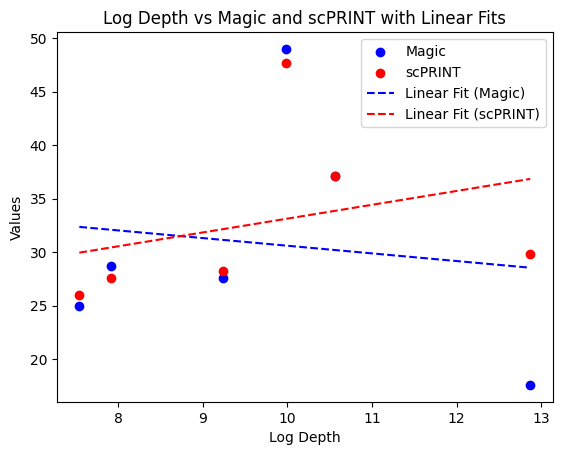

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
data = {
    "depth": [1888, 2736, 388362, 10360, 21693, 38469],
    "magic": [25, 28.7, 17.6, 27.6, 49, 37.1],
    "scprint": [26, 27.6, 29.8, 28.2, 47.7, 37.1],
}
df = pd.DataFrame(data)

# Convert depth to log scale
df["log_depth"] = np.log(df["depth"])


# Define a linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b


# Fit the linear curves on log scale
popt_magic, _ = curve_fit(linear_func, df["log_depth"], df["magic"])
popt_scprint, _ = curve_fit(linear_func, df["log_depth"], df["scprint"])

# Plot the data points
plt.scatter(df["log_depth"], df["magic"], label="Magic", color="blue")
plt.scatter(df["log_depth"], df["scprint"], label="scPRINT", color="red")

# Plot the fitted linear curves
x_values = np.linspace(min(df["log_depth"]), max(df["log_depth"]), 100)
plt.plot(
    x_values,
    linear_func(x_values, *popt_magic),
    label="Linear Fit (Magic)",
    color="blue",
    linestyle="--",
)
plt.plot(
    x_values,
    linear_func(x_values, *popt_scprint),
    label="Linear Fit (scPRINT)",
    color="red",
    linestyle="--",
)

# Add labels and legend
plt.xlabel("Log Depth")
plt.ylabel("Values")
plt.legend()
plt.title("Log Depth vs Magic and scPRINT with Linear Fits")
plt.show()

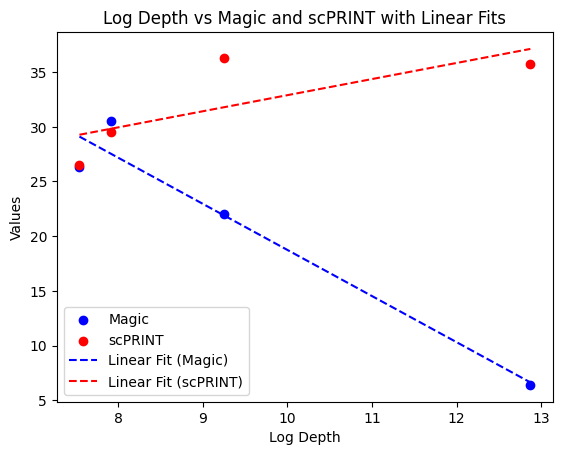

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
data = {
    "depth": [2736, 1888, 388362, 10360],
    "magic": [30.5, 26.3, 6.4, 22.0],
    "scprint": [29.5, 26.5, 35.7, 36.3],
}
df = pd.DataFrame(data)

# Convert depth to log scale
df["log_depth"] = np.log(df["depth"])


# Define a linear function for curve fitting
def linear_func(x, a, b):
    return a * x + b


# Fit the linear curves on log scale
popt_magic, _ = curve_fit(linear_func, df["log_depth"], df["magic"])
popt_scprint, _ = curve_fit(linear_func, df["log_depth"], df["scprint"])

# Plot the data points
plt.scatter(df["log_depth"], df["magic"], label="Magic", color="blue")
plt.scatter(df["log_depth"], df["scprint"], label="scPRINT", color="red")

# Plot the fitted linear curves
x_values = np.linspace(min(df["log_depth"]), max(df["log_depth"]), 100)
plt.plot(
    x_values,
    linear_func(x_values, *popt_magic),
    label="Linear Fit (Magic)",
    color="blue",
    linestyle="--",
)
plt.plot(
    x_values,
    linear_func(x_values, *popt_scprint),
    label="Linear Fit (scPRINT)",
    color="red",
    linestyle="--",
)

# Add labels and legend
plt.xlabel("Log Depth")
plt.ylabel("Values")
plt.legend()
plt.title("Log Depth vs Magic and scPRINT with Linear Fits")
plt.show()


2498.7604421298756 10360.862 9409


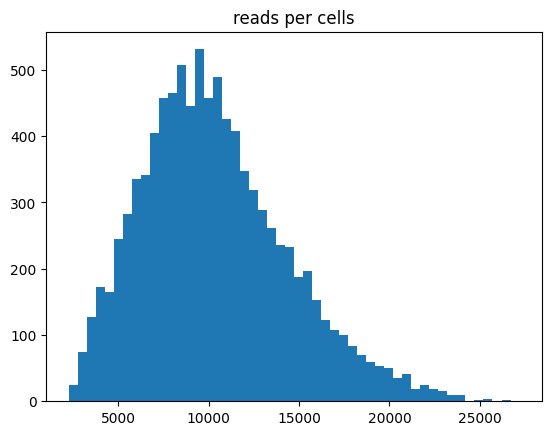

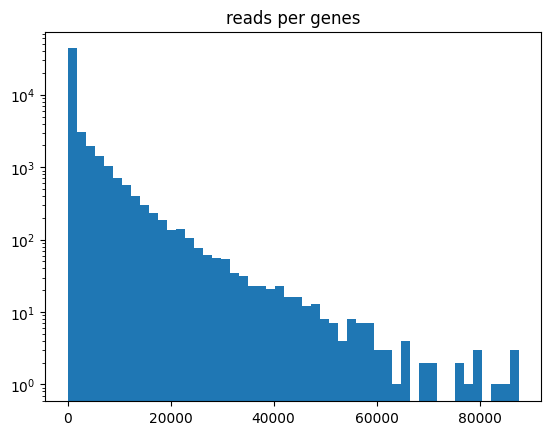

In [10]:
adata = sc.read(LOC + "lung_smart" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.yscale("log")
plt.title("reads per genes")
plt.show()
# 4x

2510.0482028420174 388362.5 3589


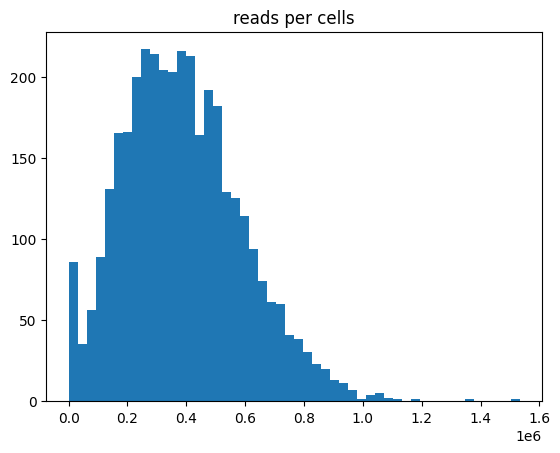

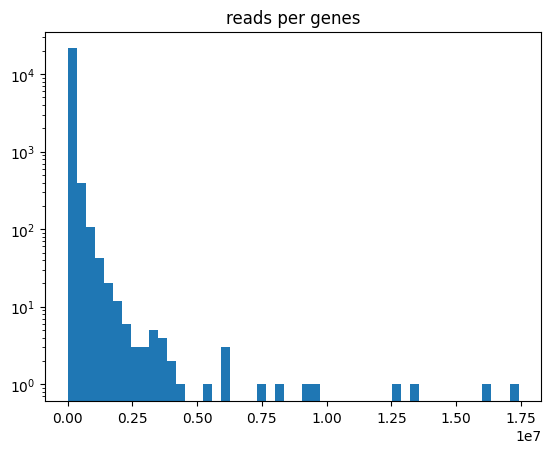

In [11]:
adata = sc.read(LOC + "glio_smart_highdepth" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.yscale("log")
plt.title("reads per genes")
plt.show()
# 14x

5190.719223565469 38469.57 5873


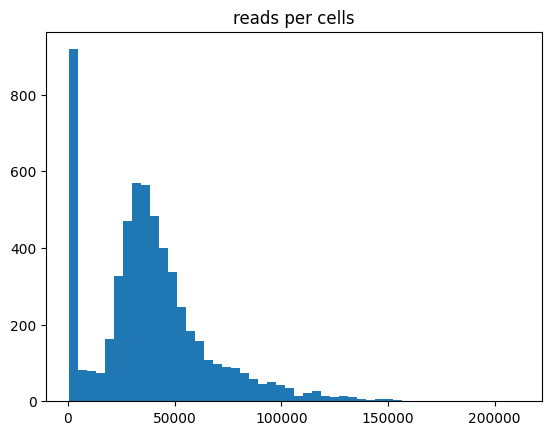

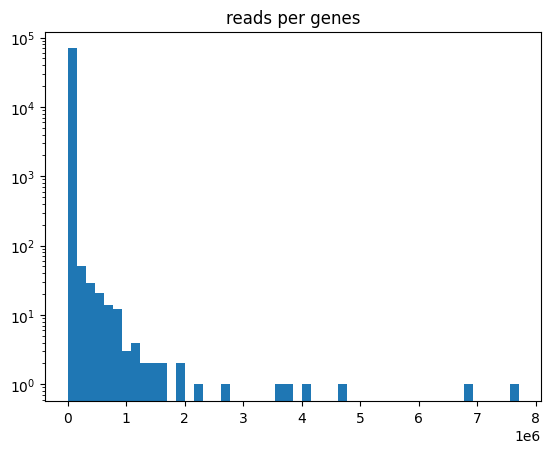

In [12]:
adata = sc.read(LOC + "SRX24486462" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.yscale("log")
plt.title("reads per genes")
plt.show()
# 7x

4145.619956883277 21693.55 3247


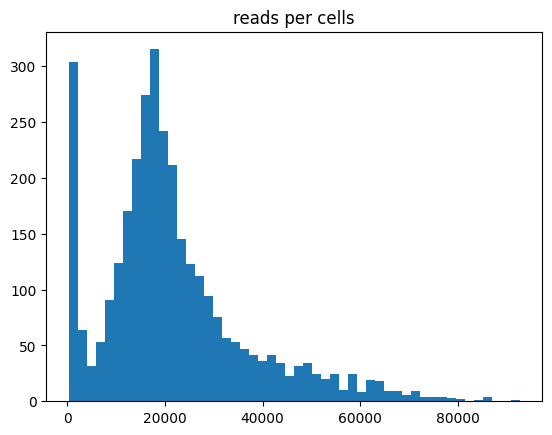

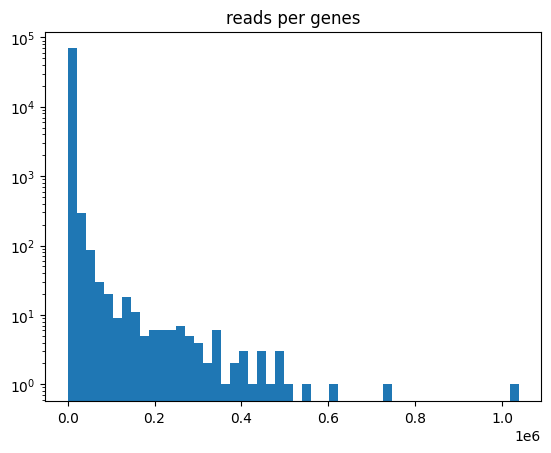

In [13]:
adata = sc.read(LOC + "SRX22526970" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.title("reads per genes")
plt.yscale("log")
plt.show()
# 5x

1982.6642332040024 1888.9308 39176


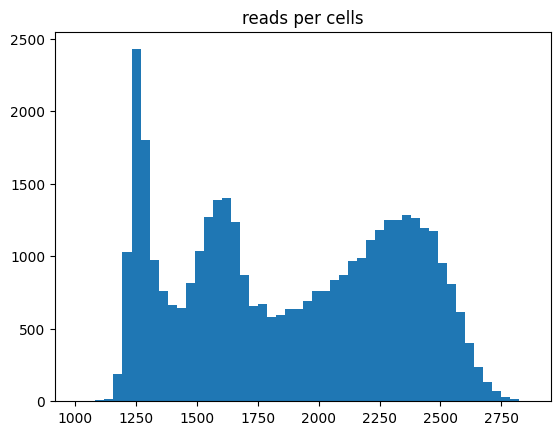

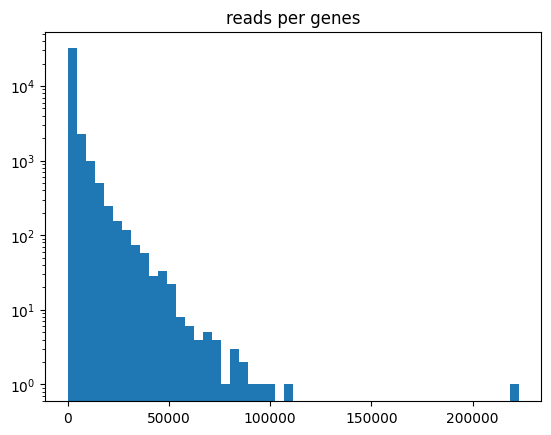

In [14]:
adata = sc.read(LOC + "kidney" + ".h5ad")
print((adata.X > 0).sum(1).mean(), adata.X.sum(1).mean(), adata.shape[0])
plt.hist(np.array(adata.X.sum(1)).T[0], bins=50)
plt.title("reads per cells")
plt.show()
plt.hist(np.array(adata.X.sum(0))[0], bins=50)
plt.title("reads per genes")
plt.yscale("log")
plt.show()
# 1x

In [15]:
adata = sc.read(LOC + "lung_smart" + ".h5ad")

In [16]:
preprocessor = Preprocessor(
    force_preprocess=True, skip_validate=True, drop_non_primary=False, do_postp=False
)
preprocessor = Preprocessor(do_postp=False)
adata = preprocessor(adata)
adata.layers["true"] = adata.X.copy()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 9409 renamining


filtered out 0 cells, 9409 renamining


Removed 0 genes not known to the ontology


Removed 0 duplicate genes
Added 15701 genes in the ontology but not present in the dataset


starting QC


Seeing 5471 outliers (58.14% of total dataset):


done
AnnData object with n_obs × n_vars = 9409 × 70116
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'lo

In [17]:
denoise = Denoiser(
    batch_size=40 if adata.X.sum(1).mean() < 50_000 else 20,
    max_len=8_000,
    max_cells=100_000,
    doplot=False,
    num_workers=8,
    predict_depth_mult=5,
    downsample_expr=0.7,
)

In [18]:
_, idx, nadata = denoise(model, adata)

working on 4288 accepted genes


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 1/471 [00:01<11:11,  1.43s/it]

  0%|          | 2/471 [00:01<05:28,  1.43it/s]

  1%|          | 3/471 [00:01<03:36,  2.16it/s]

  1%|          | 4/471 [00:01<02:44,  2.84it/s]

  1%|          | 5/471 [00:02<02:14,  3.46it/s]

  1%|▏         | 6/471 [00:02<01:57,  3.97it/s]

  1%|▏         | 7/471 [00:02<01:45,  4.39it/s]

  2%|▏         | 8/471 [00:02<01:38,  4.69it/s]

  2%|▏         | 9/471 [00:02<01:33,  4.92it/s]

  2%|▏         | 10/471 [00:03<01:30,  5.10it/s]

  2%|▏         | 11/471 [00:03<01:27,  5.26it/s]

  3%|▎         | 12/471 [00:03<01:26,  5.33it/s]

  3%|▎         | 13/471 [00:03<01:25,  5.38it/s]

  3%|▎         | 14/471 [00:03<01:24,  5.42it/s]

  3%|▎         | 15/471 [00:03<01:23,  5.43it/s]

  3%|▎         | 16/471 [00:04<01:23,  5.44it/s]

  4%|▎         | 17/471 [00:04<01:22,  5.49it/s]

  4%|▍         | 18/471 [00:04<01:21,  5.53it/s]

  4%|▍         | 19/471 [00:04<01:22,  5.50it/s]

  4%|▍         | 20/471 [00:04<01:22,  5.48it/s]

  4%|▍         | 21/471 [00:05<01:21,  5.51it/s]

  5%|▍         | 22/471 [00:05<01:20,  5.56it/s]

  5%|▍         | 23/471 [00:05<01:21,  5.50it/s]

  5%|▌         | 24/471 [00:05<01:20,  5.54it/s]

  5%|▌         | 25/471 [00:05<01:20,  5.52it/s]

  6%|▌         | 26/471 [00:05<01:19,  5.59it/s]

  6%|▌         | 27/471 [00:06<01:40,  4.40it/s]

  6%|▌         | 28/471 [00:06<01:35,  4.63it/s]

  6%|▌         | 29/471 [00:06<01:31,  4.81it/s]

  6%|▋         | 30/471 [00:06<01:27,  5.02it/s]

  7%|▋         | 31/471 [00:07<01:24,  5.18it/s]

  7%|▋         | 32/471 [00:07<01:22,  5.31it/s]

  7%|▋         | 33/471 [00:07<01:21,  5.39it/s]

  7%|▋         | 34/471 [00:07<01:20,  5.46it/s]

  7%|▋         | 35/471 [00:07<01:19,  5.50it/s]

  8%|▊         | 36/471 [00:07<01:20,  5.41it/s]

  8%|▊         | 37/471 [00:08<01:19,  5.46it/s]

  8%|▊         | 38/471 [00:08<01:18,  5.52it/s]

  8%|▊         | 39/471 [00:08<01:19,  5.40it/s]

  8%|▊         | 40/471 [00:08<01:21,  5.32it/s]

  9%|▊         | 41/471 [00:08<01:20,  5.37it/s]

  9%|▉         | 42/471 [00:09<01:18,  5.48it/s]

  9%|▉         | 43/471 [00:09<01:17,  5.49it/s]

  9%|▉         | 44/471 [00:09<01:17,  5.53it/s]

 10%|▉         | 45/471 [00:09<01:16,  5.56it/s]

 10%|▉         | 46/471 [00:09<01:16,  5.55it/s]

 10%|▉         | 47/471 [00:09<01:16,  5.57it/s]

 10%|█         | 48/471 [00:10<01:15,  5.59it/s]

 10%|█         | 49/471 [00:10<01:15,  5.56it/s]

 11%|█         | 50/471 [00:10<01:15,  5.60it/s]

 11%|█         | 51/471 [00:10<01:14,  5.60it/s]

 11%|█         | 52/471 [00:10<01:15,  5.57it/s]

 11%|█▏        | 53/471 [00:10<01:14,  5.59it/s]

 11%|█▏        | 54/471 [00:11<01:14,  5.60it/s]

 12%|█▏        | 55/471 [00:11<01:16,  5.43it/s]

 12%|█▏        | 56/471 [00:11<01:15,  5.48it/s]

 12%|█▏        | 57/471 [00:11<01:15,  5.52it/s]

 12%|█▏        | 58/471 [00:11<01:14,  5.52it/s]

 13%|█▎        | 59/471 [00:12<01:14,  5.56it/s]

 13%|█▎        | 60/471 [00:12<01:13,  5.58it/s]

 13%|█▎        | 61/471 [00:12<01:13,  5.58it/s]

 13%|█▎        | 62/471 [00:12<01:13,  5.58it/s]

 13%|█▎        | 63/471 [00:12<01:12,  5.59it/s]

 14%|█▎        | 64/471 [00:12<01:12,  5.59it/s]

 14%|█▍        | 65/471 [00:13<01:12,  5.59it/s]

 14%|█▍        | 66/471 [00:13<01:12,  5.59it/s]

 14%|█▍        | 67/471 [00:13<01:12,  5.59it/s]

 14%|█▍        | 68/471 [00:13<01:12,  5.59it/s]

 15%|█▍        | 69/471 [00:13<01:11,  5.60it/s]

 15%|█▍        | 70/471 [00:14<01:11,  5.58it/s]

 15%|█▌        | 71/471 [00:14<01:11,  5.59it/s]

 15%|█▌        | 72/471 [00:14<01:11,  5.59it/s]

 15%|█▌        | 73/471 [00:14<01:11,  5.58it/s]

 16%|█▌        | 74/471 [00:14<01:11,  5.58it/s]

 16%|█▌        | 75/471 [00:14<01:10,  5.59it/s]

 16%|█▌        | 76/471 [00:15<01:10,  5.58it/s]

 16%|█▋        | 77/471 [00:15<01:10,  5.58it/s]

 17%|█▋        | 78/471 [00:15<01:10,  5.58it/s]

 17%|█▋        | 79/471 [00:15<01:10,  5.58it/s]

 17%|█▋        | 80/471 [00:15<01:10,  5.57it/s]

 17%|█▋        | 81/471 [00:16<01:09,  5.58it/s]

 17%|█▋        | 82/471 [00:16<01:09,  5.58it/s]

 18%|█▊        | 83/471 [00:16<01:09,  5.58it/s]

 18%|█▊        | 84/471 [00:16<01:09,  5.58it/s]

 18%|█▊        | 85/471 [00:16<01:09,  5.57it/s]

 18%|█▊        | 86/471 [00:16<01:09,  5.57it/s]

 18%|█▊        | 87/471 [00:17<01:08,  5.57it/s]

 19%|█▊        | 88/471 [00:17<01:08,  5.57it/s]

 19%|█▉        | 89/471 [00:17<01:08,  5.57it/s]

 19%|█▉        | 90/471 [00:17<01:08,  5.57it/s]

 19%|█▉        | 91/471 [00:17<01:08,  5.57it/s]

 20%|█▉        | 92/471 [00:18<01:08,  5.57it/s]

 20%|█▉        | 93/471 [00:18<01:07,  5.57it/s]

 20%|█▉        | 94/471 [00:18<01:07,  5.57it/s]

 20%|██        | 95/471 [00:18<01:07,  5.57it/s]

 20%|██        | 96/471 [00:18<01:07,  5.57it/s]

 21%|██        | 97/471 [00:18<01:07,  5.57it/s]

 21%|██        | 98/471 [00:19<01:06,  5.57it/s]

 21%|██        | 99/471 [00:19<01:07,  5.52it/s]

 21%|██        | 100/471 [00:19<01:07,  5.52it/s]

 21%|██▏       | 101/471 [00:19<01:07,  5.49it/s]

 22%|██▏       | 102/471 [00:19<01:07,  5.50it/s]

 22%|██▏       | 103/471 [00:19<01:07,  5.48it/s]

 22%|██▏       | 104/471 [00:20<01:06,  5.50it/s]

 22%|██▏       | 105/471 [00:20<01:07,  5.45it/s]

 23%|██▎       | 106/471 [00:20<01:06,  5.47it/s]

 23%|██▎       | 107/471 [00:20<01:06,  5.45it/s]

 23%|██▎       | 108/471 [00:20<01:06,  5.48it/s]

 23%|██▎       | 109/471 [00:21<01:06,  5.46it/s]

 23%|██▎       | 110/471 [00:21<01:05,  5.48it/s]

 24%|██▎       | 111/471 [00:21<01:06,  5.45it/s]

 24%|██▍       | 112/471 [00:21<01:05,  5.47it/s]

 24%|██▍       | 113/471 [00:21<01:05,  5.44it/s]

 24%|██▍       | 114/471 [00:22<01:05,  5.47it/s]

 24%|██▍       | 115/471 [00:22<01:05,  5.45it/s]

 25%|██▍       | 116/471 [00:22<01:04,  5.48it/s]

 25%|██▍       | 117/471 [00:22<01:05,  5.44it/s]

 25%|██▌       | 118/471 [00:22<01:04,  5.46it/s]

 25%|██▌       | 119/471 [00:22<01:04,  5.44it/s]

 25%|██▌       | 120/471 [00:23<01:04,  5.48it/s]

 26%|██▌       | 121/471 [00:23<01:04,  5.44it/s]

 26%|██▌       | 122/471 [00:23<01:03,  5.46it/s]

 26%|██▌       | 123/471 [00:23<01:04,  5.43it/s]

 26%|██▋       | 124/471 [00:23<01:03,  5.45it/s]

 27%|██▋       | 125/471 [00:24<01:03,  5.44it/s]

 27%|██▋       | 126/471 [00:24<01:03,  5.46it/s]

 27%|██▋       | 127/471 [00:24<01:03,  5.44it/s]

 27%|██▋       | 128/471 [00:24<01:02,  5.46it/s]

 27%|██▋       | 129/471 [00:24<01:03,  5.43it/s]

 28%|██▊       | 130/471 [00:24<01:02,  5.45it/s]

 28%|██▊       | 131/471 [00:25<01:02,  5.43it/s]

 28%|██▊       | 132/471 [00:25<01:02,  5.45it/s]

 28%|██▊       | 133/471 [00:25<01:02,  5.43it/s]

 28%|██▊       | 134/471 [00:25<01:01,  5.45it/s]

 29%|██▊       | 135/471 [00:25<01:03,  5.30it/s]

 29%|██▉       | 136/471 [00:26<01:02,  5.35it/s]

 29%|██▉       | 137/471 [00:26<01:02,  5.36it/s]

 29%|██▉       | 138/471 [00:26<01:01,  5.40it/s]

 30%|██▉       | 139/471 [00:26<01:01,  5.38it/s]

 30%|██▉       | 140/471 [00:26<01:01,  5.41it/s]

 30%|██▉       | 141/471 [00:26<01:01,  5.39it/s]

 30%|███       | 142/471 [00:27<01:00,  5.41it/s]

 30%|███       | 143/471 [00:27<01:00,  5.40it/s]

 31%|███       | 144/471 [00:27<01:00,  5.43it/s]

 31%|███       | 145/471 [00:27<01:00,  5.40it/s]

 31%|███       | 146/471 [00:27<00:59,  5.42it/s]

 31%|███       | 147/471 [00:28<01:00,  5.40it/s]

 31%|███▏      | 148/471 [00:28<00:59,  5.41it/s]

 32%|███▏      | 149/471 [00:28<00:59,  5.38it/s]

 32%|███▏      | 150/471 [00:28<00:59,  5.39it/s]

 32%|███▏      | 151/471 [00:28<00:59,  5.37it/s]

 32%|███▏      | 152/471 [00:29<00:59,  5.40it/s]

 32%|███▏      | 153/471 [00:29<00:59,  5.38it/s]

 33%|███▎      | 154/471 [00:29<00:58,  5.40it/s]

 33%|███▎      | 155/471 [00:29<00:58,  5.37it/s]

 33%|███▎      | 156/471 [00:29<00:58,  5.39it/s]

 33%|███▎      | 157/471 [00:29<00:58,  5.37it/s]

 34%|███▎      | 158/471 [00:30<00:58,  5.32it/s]

 34%|███▍      | 159/471 [00:30<00:59,  5.26it/s]

 34%|███▍      | 160/471 [00:30<00:58,  5.28it/s]

 34%|███▍      | 161/471 [00:30<00:58,  5.28it/s]

 34%|███▍      | 162/471 [00:30<00:58,  5.27it/s]

 35%|███▍      | 163/471 [00:31<00:58,  5.25it/s]

 35%|███▍      | 164/471 [00:31<00:58,  5.24it/s]

 35%|███▌      | 165/471 [00:31<00:58,  5.22it/s]

 35%|███▌      | 166/471 [00:31<00:58,  5.23it/s]

 35%|███▌      | 167/471 [00:31<00:58,  5.23it/s]

 36%|███▌      | 168/471 [00:32<00:57,  5.24it/s]

 36%|███▌      | 169/471 [00:32<00:57,  5.23it/s]

 36%|███▌      | 170/471 [00:32<00:57,  5.23it/s]

 36%|███▋      | 171/471 [00:32<00:57,  5.22it/s]

 37%|███▋      | 172/471 [00:32<00:57,  5.23it/s]

 37%|███▋      | 173/471 [00:33<00:56,  5.23it/s]

 37%|███▋      | 174/471 [00:33<00:56,  5.24it/s]

 37%|███▋      | 175/471 [00:33<00:56,  5.23it/s]

 37%|███▋      | 176/471 [00:33<00:56,  5.22it/s]

 38%|███▊      | 177/471 [00:33<00:56,  5.20it/s]

 38%|███▊      | 178/471 [00:33<00:56,  5.21it/s]

 38%|███▊      | 179/471 [00:34<00:55,  5.22it/s]

 38%|███▊      | 180/471 [00:34<00:55,  5.21it/s]

 38%|███▊      | 181/471 [00:34<00:55,  5.21it/s]

 39%|███▊      | 182/471 [00:34<00:55,  5.20it/s]

 39%|███▉      | 183/471 [00:34<00:55,  5.19it/s]

 39%|███▉      | 184/471 [00:35<00:55,  5.19it/s]

 39%|███▉      | 185/471 [00:35<00:54,  5.21it/s]

 39%|███▉      | 186/471 [00:35<00:54,  5.21it/s]

 40%|███▉      | 187/471 [00:35<00:54,  5.21it/s]

 40%|███▉      | 188/471 [00:35<00:54,  5.19it/s]

 40%|████      | 189/471 [00:36<00:54,  5.20it/s]

 40%|████      | 190/471 [00:36<00:54,  5.20it/s]

 41%|████      | 191/471 [00:36<00:53,  5.22it/s]

 41%|████      | 192/471 [00:36<00:53,  5.21it/s]

 41%|████      | 193/471 [00:36<00:53,  5.20it/s]

 41%|████      | 194/471 [00:37<00:53,  5.18it/s]

 41%|████▏     | 195/471 [00:37<00:53,  5.19it/s]

 42%|████▏     | 196/471 [00:37<00:53,  5.19it/s]

 42%|████▏     | 197/471 [00:37<00:52,  5.21it/s]

 42%|████▏     | 198/471 [00:37<00:52,  5.20it/s]

 42%|████▏     | 199/471 [00:38<00:52,  5.20it/s]

 42%|████▏     | 200/471 [00:38<00:52,  5.18it/s]

 43%|████▎     | 201/471 [00:38<00:52,  5.18it/s]

 43%|████▎     | 202/471 [00:38<00:51,  5.18it/s]

 43%|████▎     | 203/471 [00:38<00:51,  5.19it/s]

 43%|████▎     | 204/471 [00:38<00:51,  5.19it/s]

 44%|████▎     | 205/471 [00:39<00:51,  5.19it/s]

 44%|████▎     | 206/471 [00:39<00:51,  5.18it/s]

 44%|████▍     | 207/471 [00:39<00:51,  5.15it/s]

 44%|████▍     | 208/471 [00:39<00:50,  5.17it/s]

 44%|████▍     | 209/471 [00:39<00:50,  5.18it/s]

 45%|████▍     | 210/471 [00:40<00:50,  5.17it/s]

 45%|████▍     | 211/471 [00:40<00:50,  5.17it/s]

 45%|████▌     | 212/471 [00:40<00:50,  5.16it/s]

 45%|████▌     | 213/471 [00:40<00:50,  5.16it/s]

 45%|████▌     | 214/471 [00:40<00:50,  5.14it/s]

 46%|████▌     | 215/471 [00:41<00:49,  5.14it/s]

 46%|████▌     | 216/471 [00:41<00:49,  5.17it/s]

 46%|████▌     | 217/471 [00:41<00:49,  5.16it/s]

 46%|████▋     | 218/471 [00:41<00:49,  5.15it/s]

 46%|████▋     | 219/471 [00:41<00:48,  5.14it/s]

 47%|████▋     | 220/471 [00:42<00:48,  5.15it/s]

 47%|████▋     | 221/471 [00:42<00:48,  5.16it/s]

 47%|████▋     | 222/471 [00:42<00:48,  5.16it/s]

 47%|████▋     | 223/471 [00:42<00:48,  5.16it/s]

 48%|████▊     | 224/471 [00:42<00:48,  5.15it/s]

 48%|████▊     | 225/471 [00:43<00:47,  5.13it/s]

 48%|████▊     | 226/471 [00:43<00:47,  5.12it/s]

 48%|████▊     | 227/471 [00:43<00:47,  5.13it/s]

 48%|████▊     | 228/471 [00:43<00:47,  5.13it/s]

 49%|████▊     | 229/471 [00:43<00:47,  5.13it/s]

 49%|████▉     | 230/471 [00:44<00:47,  5.13it/s]

 49%|████▉     | 231/471 [00:44<00:46,  5.12it/s]

 49%|████▉     | 232/471 [00:44<00:46,  5.11it/s]

 49%|████▉     | 233/471 [00:44<00:46,  5.11it/s]

 50%|████▉     | 234/471 [00:44<00:46,  5.12it/s]

 50%|████▉     | 235/471 [00:45<00:46,  5.12it/s]

 50%|█████     | 236/471 [00:45<00:46,  5.08it/s]

 50%|█████     | 237/471 [00:45<00:45,  5.12it/s]

 51%|█████     | 238/471 [00:45<00:45,  5.10it/s]

 51%|█████     | 239/471 [00:45<00:45,  5.11it/s]

 51%|█████     | 240/471 [00:45<00:45,  5.11it/s]

 51%|█████     | 241/471 [00:46<00:44,  5.11it/s]

 51%|█████▏    | 242/471 [00:46<00:44,  5.12it/s]

 52%|█████▏    | 243/471 [00:46<00:44,  5.11it/s]

 52%|█████▏    | 244/471 [00:46<00:44,  5.09it/s]

 52%|█████▏    | 245/471 [00:46<00:44,  5.10it/s]

 52%|█████▏    | 246/471 [00:47<00:44,  5.11it/s]

 52%|█████▏    | 247/471 [00:47<00:43,  5.11it/s]

 53%|█████▎    | 248/471 [00:47<00:43,  5.11it/s]

 53%|█████▎    | 249/471 [00:47<00:43,  5.10it/s]

 53%|█████▎    | 250/471 [00:47<00:43,  5.09it/s]

 53%|█████▎    | 251/471 [00:48<00:43,  5.10it/s]

 54%|█████▎    | 252/471 [00:48<00:42,  5.10it/s]

 54%|█████▎    | 253/471 [00:48<00:42,  5.10it/s]

 54%|█████▍    | 254/471 [00:48<00:42,  5.09it/s]

 54%|█████▍    | 255/471 [00:48<00:42,  5.09it/s]

 54%|█████▍    | 256/471 [00:49<00:42,  5.08it/s]

 55%|█████▍    | 257/471 [00:49<00:42,  5.08it/s]

 55%|█████▍    | 258/471 [00:49<00:41,  5.09it/s]

 55%|█████▍    | 259/471 [00:49<00:41,  5.09it/s]

 55%|█████▌    | 260/471 [00:49<00:41,  5.09it/s]

 55%|█████▌    | 261/471 [00:50<00:41,  5.09it/s]

 56%|█████▌    | 262/471 [00:50<00:41,  5.05it/s]

 56%|█████▌    | 263/471 [00:50<00:40,  5.09it/s]

 56%|█████▌    | 264/471 [00:50<00:42,  4.87it/s]

 56%|█████▋    | 265/471 [00:50<00:39,  5.17it/s]

 56%|█████▋    | 266/471 [00:51<00:39,  5.14it/s]

 57%|█████▋    | 267/471 [00:51<00:39,  5.12it/s]

 57%|█████▋    | 268/471 [00:51<00:39,  5.09it/s]

 57%|█████▋    | 269/471 [00:51<00:39,  5.09it/s]

 57%|█████▋    | 270/471 [00:51<00:39,  5.09it/s]

 58%|█████▊    | 271/471 [00:52<00:39,  5.09it/s]

 58%|█████▊    | 272/471 [00:52<00:39,  5.09it/s]

 58%|█████▊    | 273/471 [00:52<00:39,  5.08it/s]

 58%|█████▊    | 274/471 [00:52<00:38,  5.06it/s]

 58%|█████▊    | 275/471 [00:52<00:38,  5.03it/s]

 59%|█████▊    | 276/471 [00:53<00:38,  5.07it/s]

 59%|█████▉    | 277/471 [00:53<00:38,  5.09it/s]

 59%|█████▉    | 278/471 [00:53<00:37,  5.10it/s]

 59%|█████▉    | 279/471 [00:53<00:37,  5.09it/s]

 59%|█████▉    | 280/471 [00:53<00:37,  5.09it/s]

 60%|█████▉    | 281/471 [00:54<00:37,  5.07it/s]

 60%|█████▉    | 282/471 [00:54<00:37,  5.07it/s]

 60%|██████    | 283/471 [00:54<00:36,  5.09it/s]

 60%|██████    | 284/471 [00:54<00:36,  5.10it/s]

 61%|██████    | 285/471 [00:54<00:36,  5.09it/s]

 61%|██████    | 286/471 [00:55<00:36,  5.08it/s]

 61%|██████    | 287/471 [00:55<00:36,  5.07it/s]

 61%|██████    | 288/471 [00:55<00:36,  5.04it/s]

 61%|██████▏   | 289/471 [00:55<00:35,  5.09it/s]

 62%|██████▏   | 290/471 [00:55<00:35,  5.09it/s]

 62%|██████▏   | 291/471 [00:56<00:35,  5.09it/s]

 62%|██████▏   | 292/471 [00:56<00:35,  5.08it/s]

 62%|██████▏   | 293/471 [00:56<00:35,  5.06it/s]

 62%|██████▏   | 294/471 [00:56<00:34,  5.07it/s]

 63%|██████▎   | 295/471 [00:56<00:34,  5.08it/s]

 63%|██████▎   | 296/471 [00:57<00:34,  5.08it/s]

 63%|██████▎   | 297/471 [00:57<00:34,  5.08it/s]

 63%|██████▎   | 298/471 [00:57<00:34,  5.07it/s]

 63%|██████▎   | 299/471 [00:57<00:34,  5.06it/s]

 64%|██████▎   | 300/471 [00:57<00:33,  5.06it/s]

 64%|██████▍   | 301/471 [00:57<00:33,  5.06it/s]

 64%|██████▍   | 302/471 [00:58<00:33,  5.07it/s]

 64%|██████▍   | 303/471 [00:58<00:33,  5.07it/s]

 65%|██████▍   | 304/471 [00:58<00:32,  5.07it/s]

 65%|██████▍   | 305/471 [00:58<00:32,  5.05it/s]

 65%|██████▍   | 306/471 [00:58<00:32,  5.06it/s]

 65%|██████▌   | 307/471 [00:59<00:32,  5.07it/s]

 65%|██████▌   | 308/471 [00:59<00:32,  5.07it/s]

 66%|██████▌   | 309/471 [00:59<00:32,  5.06it/s]

 66%|██████▌   | 310/471 [00:59<00:31,  5.05it/s]

 66%|██████▌   | 311/471 [00:59<00:31,  5.04it/s]

 66%|██████▌   | 312/471 [01:00<00:31,  5.04it/s]

 66%|██████▋   | 313/471 [01:00<00:31,  5.05it/s]

 67%|██████▋   | 314/471 [01:00<00:31,  5.01it/s]

 67%|██████▋   | 315/471 [01:00<00:30,  5.06it/s]

 67%|██████▋   | 316/471 [01:00<00:30,  5.04it/s]

 67%|██████▋   | 317/471 [01:01<00:30,  5.03it/s]

 68%|██████▊   | 318/471 [01:01<00:30,  5.03it/s]

 68%|██████▊   | 319/471 [01:01<00:30,  5.05it/s]

 68%|██████▊   | 320/471 [01:01<00:29,  5.05it/s]

 68%|██████▊   | 321/471 [01:01<00:29,  5.04it/s]

 68%|██████▊   | 322/471 [01:02<00:29,  5.03it/s]

 69%|██████▊   | 323/471 [01:02<00:29,  5.02it/s]

 69%|██████▉   | 324/471 [01:02<00:29,  5.02it/s]

 69%|██████▉   | 325/471 [01:02<00:29,  5.03it/s]

 69%|██████▉   | 326/471 [01:02<00:28,  5.03it/s]

 69%|██████▉   | 327/471 [01:03<00:28,  5.03it/s]

 70%|██████▉   | 328/471 [01:03<00:28,  5.03it/s]

 70%|██████▉   | 329/471 [01:03<00:28,  5.01it/s]

 70%|███████   | 330/471 [01:03<00:28,  5.00it/s]

 70%|███████   | 331/471 [01:03<00:27,  5.00it/s]

 70%|███████   | 332/471 [01:04<00:27,  5.01it/s]

 71%|███████   | 333/471 [01:04<00:27,  5.02it/s]

 71%|███████   | 334/471 [01:04<00:27,  5.01it/s]

 71%|███████   | 335/471 [01:04<00:27,  5.01it/s]

 71%|███████▏  | 336/471 [01:04<00:27,  5.00it/s]

 72%|███████▏  | 337/471 [01:05<00:26,  5.00it/s]

 72%|███████▏  | 338/471 [01:05<00:26,  5.01it/s]

 72%|███████▏  | 339/471 [01:05<00:26,  5.02it/s]

 72%|███████▏  | 340/471 [01:05<00:26,  5.01it/s]

 72%|███████▏  | 341/471 [01:05<00:26,  4.99it/s]

 73%|███████▎  | 342/471 [01:06<00:32,  3.97it/s]

 73%|███████▎  | 343/471 [01:06<00:30,  4.24it/s]

 73%|███████▎  | 344/471 [01:06<00:28,  4.42it/s]

 73%|███████▎  | 345/471 [01:06<00:27,  4.58it/s]

 73%|███████▎  | 346/471 [01:07<00:26,  4.69it/s]

 74%|███████▎  | 347/471 [01:07<00:25,  4.77it/s]

 74%|███████▍  | 348/471 [01:07<00:25,  4.82it/s]

 74%|███████▍  | 349/471 [01:07<00:25,  4.87it/s]

 74%|███████▍  | 350/471 [01:07<00:24,  4.91it/s]

 75%|███████▍  | 351/471 [01:08<00:24,  4.93it/s]

 75%|███████▍  | 352/471 [01:08<00:24,  4.95it/s]

 75%|███████▍  | 353/471 [01:08<00:23,  4.95it/s]

 75%|███████▌  | 354/471 [01:08<00:23,  4.95it/s]

 75%|███████▌  | 355/471 [01:08<00:23,  4.96it/s]

 76%|███████▌  | 356/471 [01:09<00:23,  4.97it/s]

 76%|███████▌  | 357/471 [01:09<00:22,  4.97it/s]

 76%|███████▌  | 358/471 [01:09<00:22,  4.97it/s]

 76%|███████▌  | 359/471 [01:09<00:22,  4.97it/s]

 76%|███████▋  | 360/471 [01:09<00:22,  4.96it/s]

 77%|███████▋  | 361/471 [01:10<00:22,  4.96it/s]

 77%|███████▋  | 362/471 [01:10<00:21,  4.98it/s]

 77%|███████▋  | 363/471 [01:10<00:21,  4.98it/s]

 77%|███████▋  | 364/471 [01:10<00:21,  4.98it/s]

 77%|███████▋  | 365/471 [01:10<00:21,  4.97it/s]

 78%|███████▊  | 366/471 [01:11<00:21,  4.96it/s]

 78%|███████▊  | 367/471 [01:11<00:21,  4.95it/s]

 78%|███████▊  | 368/471 [01:11<00:20,  4.96it/s]

 78%|███████▊  | 369/471 [01:11<00:20,  4.96it/s]

 79%|███████▊  | 370/471 [01:11<00:20,  4.96it/s]

 79%|███████▉  | 371/471 [01:12<00:20,  4.96it/s]

 79%|███████▉  | 372/471 [01:12<00:20,  4.91it/s]

 79%|███████▉  | 373/471 [01:12<00:19,  4.93it/s]

 79%|███████▉  | 374/471 [01:12<00:19,  4.94it/s]

 80%|███████▉  | 375/471 [01:12<00:19,  4.95it/s]

 80%|███████▉  | 376/471 [01:13<00:19,  4.95it/s]

 80%|████████  | 377/471 [01:13<00:19,  4.94it/s]

 80%|████████  | 378/471 [01:13<00:18,  4.94it/s]

 80%|████████  | 379/471 [01:13<00:19,  4.73it/s]

 81%|████████  | 380/471 [01:13<00:18,  4.98it/s]

 81%|████████  | 381/471 [01:14<00:18,  4.98it/s]

 81%|████████  | 382/471 [01:14<00:17,  4.96it/s]

 81%|████████▏ | 383/471 [01:14<00:17,  4.96it/s]

 82%|████████▏ | 384/471 [01:14<00:17,  4.94it/s]

 82%|████████▏ | 385/471 [01:14<00:17,  4.93it/s]

 82%|████████▏ | 386/471 [01:15<00:17,  4.93it/s]

 82%|████████▏ | 387/471 [01:15<00:17,  4.92it/s]

 82%|████████▏ | 388/471 [01:15<00:16,  4.94it/s]

 83%|████████▎ | 389/471 [01:15<00:16,  4.94it/s]

 83%|████████▎ | 390/471 [01:16<00:16,  4.93it/s]

 83%|████████▎ | 391/471 [01:16<00:16,  4.92it/s]

 83%|████████▎ | 392/471 [01:16<00:16,  4.91it/s]

 83%|████████▎ | 393/471 [01:16<00:16,  4.87it/s]

 84%|████████▎ | 394/471 [01:16<00:15,  4.89it/s]

 84%|████████▍ | 395/471 [01:17<00:15,  4.90it/s]

 84%|████████▍ | 396/471 [01:17<00:15,  4.90it/s]

 84%|████████▍ | 397/471 [01:17<00:15,  4.89it/s]

 85%|████████▍ | 398/471 [01:17<00:14,  4.92it/s]

 85%|████████▍ | 399/471 [01:17<00:14,  4.92it/s]

 85%|████████▍ | 400/471 [01:18<00:14,  4.92it/s]

 85%|████████▌ | 401/471 [01:18<00:14,  4.92it/s]

 85%|████████▌ | 402/471 [01:18<00:14,  4.91it/s]

 86%|████████▌ | 403/471 [01:18<00:13,  4.90it/s]

 86%|████████▌ | 404/471 [01:18<00:13,  4.90it/s]

 86%|████████▌ | 405/471 [01:19<00:13,  4.91it/s]

 86%|████████▌ | 406/471 [01:19<00:13,  4.92it/s]

 86%|████████▋ | 407/471 [01:19<00:13,  4.91it/s]

 87%|████████▋ | 408/471 [01:19<00:12,  4.90it/s]

 87%|████████▋ | 409/471 [01:19<00:12,  4.89it/s]

 87%|████████▋ | 410/471 [01:20<00:12,  4.90it/s]

 87%|████████▋ | 411/471 [01:20<00:12,  4.91it/s]

 87%|████████▋ | 412/471 [01:20<00:12,  4.91it/s]

 88%|████████▊ | 413/471 [01:20<00:11,  4.90it/s]

 88%|████████▊ | 414/471 [01:20<00:11,  4.89it/s]

 88%|████████▊ | 415/471 [01:21<00:11,  4.89it/s]

 88%|████████▊ | 416/471 [01:21<00:11,  4.89it/s]

 89%|████████▊ | 417/471 [01:21<00:11,  4.90it/s]

 89%|████████▊ | 418/471 [01:21<00:10,  4.90it/s]

 89%|████████▉ | 419/471 [01:21<00:10,  4.89it/s]

 89%|████████▉ | 420/471 [01:22<00:10,  4.89it/s]

 89%|████████▉ | 421/471 [01:22<00:10,  4.88it/s]

 90%|████████▉ | 422/471 [01:22<00:10,  4.89it/s]

 90%|████████▉ | 423/471 [01:22<00:09,  4.89it/s]

 90%|█████████ | 424/471 [01:22<00:09,  4.88it/s]

 90%|█████████ | 425/471 [01:23<00:09,  4.89it/s]

 90%|█████████ | 426/471 [01:23<00:09,  4.88it/s]

 91%|█████████ | 427/471 [01:23<00:09,  4.87it/s]

 91%|█████████ | 428/471 [01:23<00:08,  4.88it/s]

 91%|█████████ | 429/471 [01:23<00:08,  4.88it/s]

 91%|█████████▏| 430/471 [01:24<00:08,  4.89it/s]

 92%|█████████▏| 431/471 [01:24<00:08,  4.88it/s]

 92%|█████████▏| 432/471 [01:24<00:07,  4.88it/s]

 92%|█████████▏| 433/471 [01:24<00:07,  4.87it/s]

 92%|█████████▏| 434/471 [01:25<00:07,  4.85it/s]

 92%|█████████▏| 435/471 [01:25<00:07,  4.85it/s]

 93%|█████████▎| 436/471 [01:25<00:07,  4.86it/s]

 93%|█████████▎| 437/471 [01:25<00:06,  4.87it/s]

 93%|█████████▎| 438/471 [01:25<00:06,  4.86it/s]

 93%|█████████▎| 439/471 [01:26<00:06,  4.86it/s]

 93%|█████████▎| 440/471 [01:26<00:06,  4.84it/s]

 94%|█████████▎| 441/471 [01:26<00:06,  4.85it/s]

 94%|█████████▍| 442/471 [01:26<00:05,  4.85it/s]

 94%|█████████▍| 443/471 [01:26<00:05,  4.86it/s]

 94%|█████████▍| 444/471 [01:27<00:05,  4.85it/s]

 94%|█████████▍| 445/471 [01:27<00:05,  4.85it/s]

 95%|█████████▍| 446/471 [01:27<00:05,  4.84it/s]

 95%|█████████▍| 447/471 [01:27<00:04,  4.84it/s]

 95%|█████████▌| 448/471 [01:27<00:04,  4.85it/s]

 95%|█████████▌| 449/471 [01:28<00:04,  4.85it/s]

 96%|█████████▌| 450/471 [01:28<00:04,  4.85it/s]

 96%|█████████▌| 451/471 [01:28<00:04,  4.84it/s]

 96%|█████████▌| 452/471 [01:28<00:03,  4.83it/s]

 96%|█████████▌| 453/471 [01:28<00:03,  4.83it/s]

 96%|█████████▋| 454/471 [01:29<00:03,  4.84it/s]

 97%|█████████▋| 455/471 [01:29<00:03,  4.85it/s]

 97%|█████████▋| 456/471 [01:29<00:03,  4.85it/s]

 97%|█████████▋| 457/471 [01:29<00:02,  4.84it/s]

 97%|█████████▋| 458/471 [01:29<00:02,  4.83it/s]

 97%|█████████▋| 459/471 [01:30<00:02,  4.84it/s]

 98%|█████████▊| 460/471 [01:30<00:02,  4.84it/s]

 98%|█████████▊| 461/471 [01:30<00:02,  4.84it/s]

 98%|█████████▊| 462/471 [01:30<00:01,  4.84it/s]

 98%|█████████▊| 463/471 [01:30<00:01,  4.84it/s]

 99%|█████████▊| 464/471 [01:31<00:01,  4.83it/s]

 99%|█████████▊| 465/471 [01:31<00:01,  4.83it/s]

 99%|█████████▉| 466/471 [01:31<00:01,  4.84it/s]

 99%|█████████▉| 467/471 [01:31<00:00,  4.83it/s]

 99%|█████████▉| 468/471 [01:32<00:00,  4.83it/s]

100%|█████████▉| 469/471 [01:32<00:00,  4.82it/s]

100%|█████████▉| 470/471 [01:32<00:00,  4.82it/s]

100%|██████████| 471/471 [01:32<00:00,  4.79it/s]

100%|██████████| 471/471 [01:32<00:00,  5.07it/s]

logging the anndata


AnnData object with n_obs × n_vars = 9409 × 4288
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [19]:
nadata = nadata[:, nadata.var.index.isin(adata.var.index)]
adata = adata[:, adata.var.index.isin(nadata.var.index)]

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [20]:
# Get min and max from adata
adata_min = np.array([1] * adata.X.shape[0])
adata_max = adata.X.max(1).data

# Get min and max for each row in nadata
nadata_min = nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1).min(axis=1)
nadata_max = nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1).max(axis=1)

# Rescale each row to match adata range
# Reshape the min/max arrays to match the matrix dimensions for broadcasting
nadata_min = nadata_min.reshape(-1, 1)
nadata_max = nadata_max.reshape(-1, 1)
adata_min = adata_min.reshape(-1, 1)
adata_max = adata_max.reshape(-1, 1)

# Perform the rescaling with properly shaped arrays
nadata.layers["scprint_mu"].data = (
    (nadata.layers["scprint_mu"].data.reshape(adata.X.shape[0], -1) - nadata_min)
    / (nadata_max - nadata_min)
    * (adata_max - adata_min)
    + adata_min
).flatten()


AttributeError: 'memoryview' object has no attribute 'reshape'

In [ ]:
# Create a mask for where scprint_mu is 0
zero_mask = nadata.layers["scprint_mu"] == 0
# Replace zeros with corresponding values from adata.X
nadata.layers["scprint_mu"][zero_mask] = adata.X[zero_mask]


In [ ]:
nadata.obs["cell_type"] = adata.obs["cell_type"].tolist()

In [ ]:
# Create UMAP visualization of scprint_mu layer
import scanpy as sc

# Compute UMAP
# Compute PCA first
sc.pp.pca(nadata, layer="scprint_mu", n_comps=40)

sc.pp.neighbors(nadata, use_rep="X_pca", n_neighbors=15)
sc.tl.umap(nadata, n_components=2, min_dist=0.2, spread=1.5)
nadata.obs["cell_type"] = adata.obs["cell_type"].tolist()

# Plot UMAP colored by cell type
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)


In [ ]:
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)

In [ ]:
sc.pl.umap(
    nadata,
    color="cell_type",
    title="UMAP of scPRINT denoised data",
    frameon=False,
    legend_fontsize=8,
)

In [ ]:
adata.X = downsample_profile(torch.Tensor(adata.X.toarray()), 0.7).numpy()

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(
    adata,
    color="cell_type",
    title="UMAP of noisy data",
    frameon=False,
    legend_fontsize=8,
    palette=nadata.uns["cell_type_colors"],
)

In [ ]:
adata

In [ ]:
adata.layers["true"].sum(1).mean(), adata.X.sum(1).mean()

In [ ]:
adata.obsm["X_pca"] = sc.pp.pca(adata.layers["true"])
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

# Plot UMAP colored by cell type
sc.pl.umap(
    adata,
    color="cell_type",
    title="UMAP of ground truth data",
    frameon=False,
    legend_fontsize=8,
    palette=nadata.uns["cell_type_colors"],
)

In [ ]:
scprint vs magic (full vs rare)
33.6 vs 37.7 - 28.2 vs 26.4
30 vs 20 - 28.5 vs 17.5
22.3 vs 23.5 - 23.4 vs 5.0

## with MAGIC rare cells

In [ ]:
ct = "pericyte"
subadata.obs.cell_type.value_counts()
# microglial cell, microfold cell of epithelium of small intestine, mesangial cell, pericyte

In [ ]:
reco = denoised_adata[subadata.obs.cell_type == ct].X
true = subadata[subadata.obs.cell_type == ct].layers["true"].toarray()
noisy = subadata[subadata.obs.cell_type == ct].X
corr_coef, p_value = spearmanr(
    np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

## scPRINT rare cells

In [ ]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=200,
    doplot=False,
    predict_depth_mult=6,
    downsample=0.7,
    how="most var",
)
metrics, idx, genes, expr = denoise(model, adata[adata.obs.cell_type == ct])
metrics